# Figures for the NeurIPS 2025 paper

In [ ]:
import os
import sys
import json

project_root = os.getenv("PROJECT_ROOT_STATE_DETECTION")
os.chdir(project_root)
sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom imports
from utils.metrics import *
from utils.load_dataset import *
from utils.load_results import *
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Critical diagrams
from aeon.visualisation import plot_critical_difference

## Comparing E2USD and T2S on a time series from MoCap dataset

Loading file: MoCap subject 03


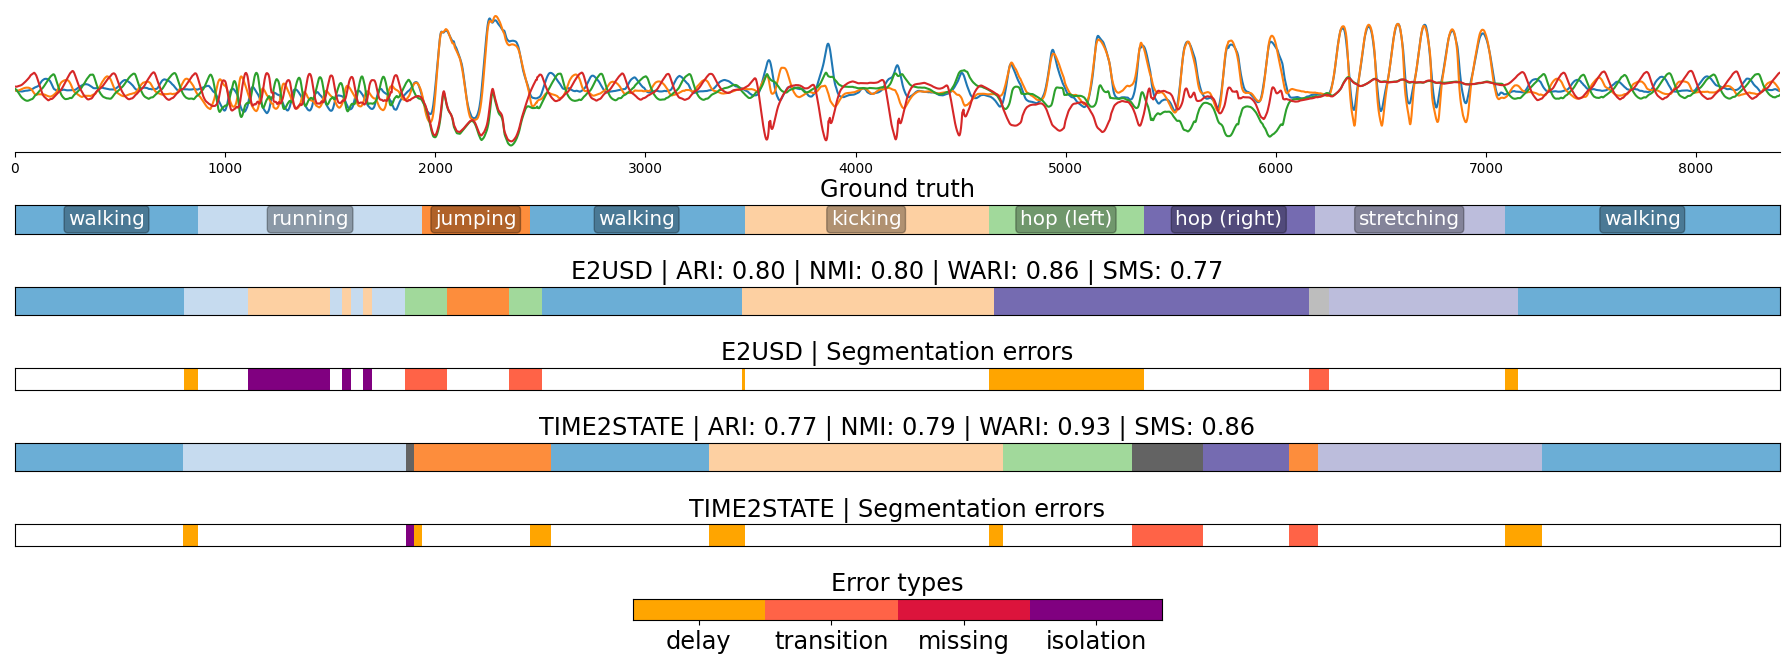

In [ ]:
dataset = 'MoCap'
params = [3]
groundtruth_state_names = ['walking', 'running', 'jumping', 'kicking', 'hop (left)', 'hop (right)', 'stretching']
algos_to_plot = ['e2usd', 'time2state']

custom_text = {
    'e2usd': 'ARI: 0.80 | WARI: 0.86 | SMS: 0.77',
    'time2state': 'ARI: 0.77 | WARI: 0.93 | SMS: 0.86'
}

weights={'delay': 0.1,
        'transition': 0.3,
        'isolation': 0.8,
        'missing': 0.5}

metrics = {
    "ARI": adjusted_rand_score,
    "NMI": normalized_mutual_info_score,
    "WARI": weighted_adjusted_rand_score,
    "WNMI": weighted_normalized_mutual_info_score,
    "SMS": state_matching_score
}

data, groundtruth = load_dataset.load_ts(dataset, params, verbose=True)

mapped_predictions_dict = {}
errors_dict = {}

for algo in algos_to_plot:
    clustering = load_results.load_clustering('multivariate', algo, dataset, params, verbose=False)
    if clustering is not None and len(clustering) > 0 :
        # Ensure groundtruth is sliced to match clustering length if they differ
        gt_sliced = groundtruth[:len(clustering)] if groundtruth is not None else None
        
        score, mapped_pred, errors_list = state_matching_score(gt_sliced, clustering, weights=weights, return_mapped=True, return_errors=True)
        mapped_predictions_dict[algo] = mapped_pred
        errors_dict[algo] = errors_list
    else:
        print(f"Warning: Clustering for {algo} is None or empty. Skipping.")
        mapped_predictions_dict[algo] = None
        errors_dict[algo] = None

plot_sms_multi(data, groundtruth=groundtruth, 
               mapped_prediction=mapped_predictions_dict, 
               errors_list=errors_dict, 
               show_error_impact=False, 
               show_error_type=True, 
               figsize=(18, 12), # Adjusted figsize for potentially more subplots
               show=True,
               groundtruth_state_names=groundtruth_state_names,
               custom_text=custom_text,
               save_path=os.path.join(project_root, 'figures', 'qualitative_example'))

## Analysing the link between proposed and existing measures (e.g. WARI/SMS vs ARI)

Display some specific examples (paper, Figure 6.) -uncomment the required one-

Loading file: PAMAP2 subject 9


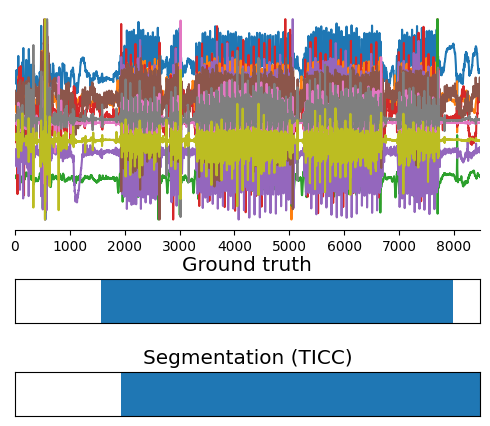

In [ ]:
# dataset = 'UCRSEG'
# params = ['InsectEPG2_50_1800.txt']
# algos_to_plot = ['ticc']

# dataset = 'UCRSEG'
# params = ['EEGRat_10_1000.txt']
# algos_to_plot = ['patss']

# dataset = 'UCRSEG'
# params = ['InsectEPG1_50_3802.txt']
# algos_to_plot = ['clasp']

# dataset = 'PAMAP2'
# params = [9]
# algos_to_plot = ['ticc']

weights={'delay': 0.1,
        'transition': 0.3,
        'isolation': 0.8,
        'missing': 0.5}

data, groundtruth = load_dataset.load_ts(dataset, params, verbose=True)

mapped_predictions_dict = {}
errors_dict = {}

for algo in algos_to_plot:
    clustering = load_results.load_clustering('multivariate', algo, dataset, params, verbose=False)
    if clustering is not None and len(clustering) > 0 :
        # Ensure groundtruth is sliced to match clustering length if they differ
        gt_sliced = groundtruth[:len(clustering)] if groundtruth is not None else None
        
        score, mapped_pred, errors_list = state_matching_score(gt_sliced, clustering, weights=weights, return_mapped=True, return_errors=True)
        mapped_predictions_dict[algo] = mapped_pred
        errors_dict[algo] = errors_list
    else:
        print(f"Warning: Clustering for {algo} is None or empty. Skipping.")
        mapped_predictions_dict[algo] = None
        errors_dict[algo] = None

plot_sms_multi(data, groundtruth=groundtruth, 
               mapped_prediction=mapped_predictions_dict, 
               errors_list=errors_dict, 
               show_error_impact=False,
               show_error_type=False, 
               figsize=(5, 3), # Adjusted figsize for potentially more subplots
               show=True,
               groundtruth_state_names=None, custom_colors=['white', 'tab:blue'],
               save_path=os.path.join(project_root, 'figures/miniplot', f'{algos_to_plot[0]}_{dataset}_{params[0]}'))

Plot SMS vs ARI

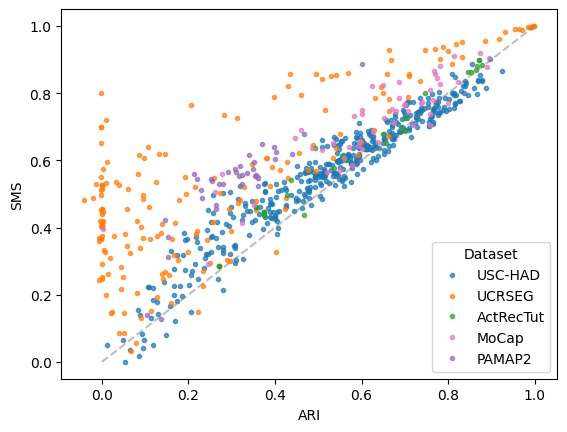

In [71]:
metric1 = 'ari'
metric2 = 'sms'
experiment_type = 'multivariate'

# Define the list of datasets and algorithms
datasets_to_plot = ['USC-HAD', 'UCRSEG', 'ActRecTut', 'MoCap', 'PAMAP2']
algorithms_to_load = ['e2usd', 'time2state', 'ticc', 'clasp', 'patss', 'hdp_hsmm']

# Define points to highlight: list of (x, y) tuples
# Using example values that might appear in your data based on context variables
highlight_points_coords = [
    (0.2911969201008294, 0.5649789799310172), 
    (0.1538045371865023, 0.3703568088854857)
]
highlight_tolerance = 0.00001 # Tolerance for float comparison

# Define a list of colors to cycle through for different datasets
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:pink', 'tab:purple', 'tab:cyan', 'tab:gray']

for dataset_name in datasets_to_plot:
    segmentation_scores = []
    clustering_scores = []
    
    for algorithm_name in algorithms_to_load:
        try:
            seg = load_results.load_metrics(experiment_type, algorithm_name, dataset_name, metric=str(metric1))
            segmentation_scores.extend(seg)
        except ValueError:
            # Optionally, print a warning or log if a metric file/column is missing
            # print(f"Warning: Could not load metric {metric1} for {algorithm_name} on {dataset_name}")
            pass 
        try:
            clus = load_results.load_metrics(experiment_type, algorithm_name, dataset_name, metric=str(metric2))
            clustering_scores.extend(clus)
        except ValueError:
            # print(f"Warning: Could not load metric {metric2} for {algorithm_name} on {dataset_name}")
            pass

    # Plot with a specific color for each dataset
    dataset_index = datasets_to_plot.index(dataset_name)
    plt.plot(segmentation_scores, clustering_scores, '.', label=f'{dataset_name}', alpha=0.7, color=colors[dataset_index % len(colors)])

# # Instead of matching by tolerance, just hard‐code the exact points with labels
# highlight_info = [
#     ("PATSS", "EEGRat_10_1000", 0.569626, 0.859174),
#     ("CLASP", "InsectEPG1_50_3802", 0.434016, 0.856881),
#     ("TICC",  "InsectEPG2_50_1800", -0.00309, 0.799447),
#     ("TICC",  "PAMAP2_9", 0.60025, 0.88682)
# ]

# # plot & annotate
# for algo, ts_name, x, y in highlight_info:
#     if algo == 'TICC' and ts_name == 'PAMAP2_9':
#         plt.scatter([x], [y],
#                     s=150,
#                     facecolors='none',
#                     edgecolors='tab:purple',
#                     linewidths=2,
#                     zorder=10,
#                     label='_nolegend_')
#         plt.text(x + 0.02, y + 0.04,
#                 #  f"{algo} \n ARI: {x:.2f}\n SMS: {y:.2f}",
#                 f"{algo}",
#                 fontsize=9,
#                 ha='left',
#                 va='bottom',
#                 bbox=dict(boxstyle='round,pad=0.3',
#                         fc='tab:purple',
#                         ec='tab:purple',
#                         alpha=0.5))
#     else:
#         plt.scatter([x], [y],
#                     s=150,
#                     facecolors='none',
#                     edgecolors='tab:orange',
#                     linewidths=2,
#                     zorder=10,
#                     label='_nolegend_')
#         plt.text(x, y + 0.05,
#                 #f"{algo} \n ARI: {x:.2f}\n SMS: {y:.2f}",
#                 f"{algo}",
#                 fontsize=9,
#                 ha='right',
#                 va='bottom',
#                 bbox=dict(boxstyle='round,pad=0.3',
#                         fc='tab:orange',
#                         ec='tab:orange',
#                         alpha=0.5))

plt.xlabel(metric1.upper())
plt.ylabel(metric2.upper())
plt.legend(title='Dataset')
plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)
plt.savefig(f'figures/{metric1}_vs_{metric2}.pdf', dpi=300, bbox_inches='tight')
plt.show()


## Critical Diagrams

Critical diagrams using AEON package: https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.visualisation.plot_critical_difference.html

Adaptation of data retrieval function

In [2]:
def get_local_estimator_results_as_dataframe(
    estimators: list[str],
    datasets: list[str],
    measure: str,
    task: str = "multivariate", # Assuming 'multivariate' based on your example path
    base_results_path: str = "results",
):
    """
    Loads results for given estimators and datasets from local CSV files,
    keeping all individual rows corresponding to dataset instances.

    Reads local files following the structure:
    {base_results_path}/{task}/score/{estimator}/{dataset}.csv

    Parameters
    ----------
    estimators : list of str
        List of estimator names (used to find the correct subdirectory).
    datasets : list of str
        List of dataset names (used to find the correct CSV file and filter rows).
    measure : str
        The specific score column name to extract from the CSV files (e.g., "ari", "f1").
    task : str, default="multivariate"
        The task type, used to determine the results subdirectory.
    base_results_path : str, default="results"
        The root directory containing the results folders.

    Returns
    -------
    results_df: pandas.DataFrame
        DataFrame containing the results. Columns include:
        - 'estimator': The name of the estimator.
        - 'dataset': The base name of the dataset (e.g., "ActRecTut").
        - 'instance': The specific instance name from the CSV (e.g., "ActRecTut_1").
        - 'score': The score value for the specified measure. NaN if the score
                   was missing or non-numeric in the CSV file.
    """
    all_results_list = []

    for dataset in datasets:
        for estimator in estimators:
            file_path = os.path.join(
                base_results_path, task, "score", estimator, f"{dataset}.csv"
            )

            if os.path.exists(file_path):
                try:
                    df = pd.read_csv(file_path)
                    # Assume the first column contains the specific dataset instance name
                    if df.empty:
                        continue
                    dataset_col = df.columns[0]

                    # Filter rows where the instance name starts with the dataset name
                    # Convert to string first to ensure .str accessor works
                    filtered_df = df[df[dataset_col].astype(str).str.startswith(dataset)].copy()


                    if not filtered_df.empty and measure in filtered_df.columns:
                        # Keep only relevant columns
                        filtered_df = filtered_df[[dataset_col, measure]]
                        # Rename dataset_col to 'instance' for clarity
                        filtered_df = filtered_df.rename(columns={dataset_col: 'instance'})
                        # Add estimator and base dataset name
                        filtered_df['estimator'] = estimator
                        filtered_df['dataset'] = dataset
                        # Convert score column to numeric, coercing errors to NaN
                        filtered_df['score'] = pd.to_numeric(filtered_df[measure], errors='coerce')
                        # Drop the original measure column if it's different from 'score'
                        if measure != 'score':
                             filtered_df = filtered_df.drop(columns=[measure])

                        # Append rows to the main list
                        all_results_list.extend(filtered_df.to_dict('records'))

                except Exception as e:
                    print(f"Error reading or processing {file_path}: {e}")
            # else: File doesn't exist, skip this estimator/dataset pair

    results_df = pd.DataFrame(all_results_list)
    # Reorder columns for better readability
    if not results_df.empty:
        results_df = results_df[['estimator', 'dataset', 'instance', 'score']]

    return results_df

# --- Example Usage ---
# Define your methods and datasets
my_estimators = ["clasp", "e2usd", "patss", "time2state", "hdp_hsmm", "ticc"] # Add other estimators that have results
my_datasets = ["ActRecTut", "MoCap", "USC-HAD", "UCRSEG"] # Add other datasets you have results for
target_measure = "sms" # Or "f1", "nmi", "covering", etc.

# Get the results as a DataFrame
results_dataframe = get_local_estimator_results_as_dataframe(
    estimators=my_estimators,
    datasets=my_datasets,
    measure=target_measure,
    task="multivariate", # Adjust if your task folder is named differently
    base_results_path="results", # Adjust if your results folder is elsewhere
)

print(f"Results DataFrame ({target_measure}):")
print(results_dataframe)

# You can now perform various operations on this DataFrame, e.g., grouping, filtering, etc.
# Example: Calculate the mean score per estimator/dataset pair (similar to previous behavior)
if not results_dataframe.empty:
    mean_scores = results_dataframe.groupby(['dataset', 'estimator'])['score'].mean().unstack()
    print("\nMean scores per estimator/dataset:")
    print(mean_scores)

# Example: Get results for a specific dataset
if not results_dataframe.empty:
    mocap_results = results_dataframe[results_dataframe['dataset'] == 'MoCap']
    print("\nResults for MoCap dataset:")
    print(mocap_results)


Results DataFrame (sms):
    estimator    dataset                                instance     score
0       clasp  ActRecTut                             ActRecTut_1  0.285834
1       clasp  ActRecTut                             ActRecTut_2  0.462202
2       clasp  ActRecTut                             ActRecTut_3  0.285834
3       clasp  ActRecTut                             ActRecTut_4  0.462202
4       clasp  ActRecTut                             ActRecTut_5  0.285834
..        ...        ...                                     ...       ...
697      ticc     UCRSEG      UCRSEG_Fetal2013_70_6000_12000.txt  0.594132
698      ticc     UCRSEG    UCRSEG_GrandMalSeizures2_10_4550.txt  0.521544
699      ticc     UCRSEG            UCRSEG_TiltECG_200_25000.txt  0.595192
700      ticc     UCRSEG  UCRSEG_SuddenCardiacDeath2_25_3250.txt  0.927296
701      ticc     UCRSEG                UCRSEG_Cane_100_2345.txt  0.512210

[702 rows x 4 columns]

Mean scores per estimator/dataset:
estimator     c

Critical diagrams for various metrics / type of data (univariate or multivariate), treating each time serie as a single instances/observation (instead of each dataset).

Using estimators: ['e2usd', 'time2state', 'hdp_hsmm', 'ticc']
Using datasets: ['ActRecTut', 'MoCap', 'USC-HAD', 'PAMAP2']

Processing metric: ARI
Plotting for 4 estimators using 94 observations (instances).
Saved critical difference plot to: figures/critical_diagram/cd_multivariate_ari.pdf


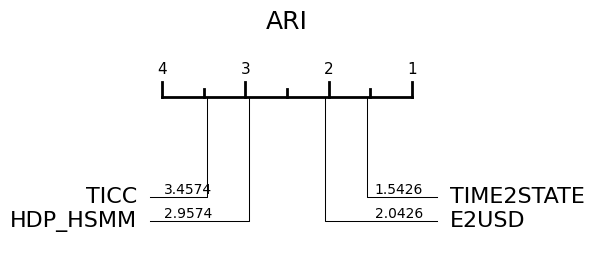


Processing metric: WARI
Plotting for 4 estimators using 94 observations (instances).
Saved critical difference plot to: figures/critical_diagram/cd_multivariate_wari.pdf


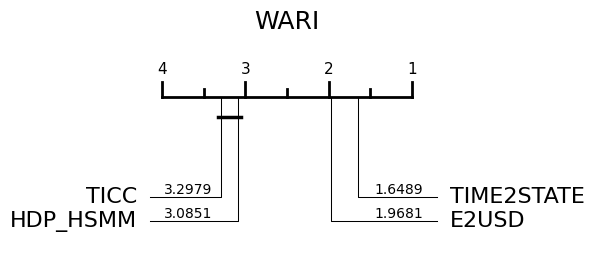


Processing metric: SMS
Plotting for 4 estimators using 94 observations (instances).
Saved critical difference plot to: figures/critical_diagram/cd_multivariate_sms.pdf


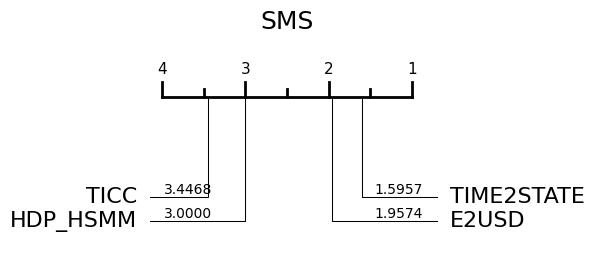

In [7]:
data_type = "multivariate" # Assuming this is the task type

if data_type == "multivariate":
    # Define the datasets and estimators for multivariate analysis
    my_datasets = ["ActRecTut", "MoCap", "USC-HAD", "PAMAP2"]
    my_estimators = ["e2usd", "time2state", "hdp_hsmm", "ticc"]
elif data_type == "univariate":
    # Define the datasets and estimators for univariate analysis
    my_datasets = ["UCRSEG"]
    my_estimators = ["e2usd", "time2state", "hdp_hsmm", "ticc", "patss", "clasp"]

target_metrics = ["ari", "wari", "sms"]
#target_metrics = ["f1", "covering"]

print(f"Using estimators: {my_estimators}")
print(f"Using datasets: {my_datasets}")

# Base path for results, use RESULTS variable if defined, otherwise default
base_results_path = globals().get('RESULTS', 'results')
task_type = "multivariate" # Assuming task type

for metric in target_metrics:
    print(f"\nProcessing metric: {metric.upper()}")

    # Get results using the function defined previously
    # This function is assumed to return an array where each row represents
    # a dataset (or potentially a specific run/fold if modified)
    # and columns represent estimators. Shape: (n_observations, n_estimators)
    # Removed 'include_missing' argument as it caused a TypeError
    # Get results using the new function which returns a DataFrame
    results_df_metric = get_local_estimator_results_as_dataframe(
        estimators=my_estimators,
        datasets=my_datasets,
        measure=metric,
        task=task_type,
        base_results_path=base_results_path
    )

    if results_df_metric.empty:
        print(f"No results data found for metric '{metric}'. Skipping plot.")
        continue

    # Pivot the DataFrame to get scores per instance (rows) and estimator (columns)
    # Use a multi-index ('dataset', 'instance') to uniquely identify each observation row
    try:
        pivoted_scores_metric = results_df_metric.pivot_table(
        index=['dataset', 'instance'],
        columns='estimator',
        values='score'
        )
    except ValueError as e:
        print(f"Error pivoting data for metric '{metric}': {e}. This might indicate duplicate entries for the same (dataset, instance, estimator). Skipping plot.")
        # Optional: Add debugging here to inspect results_df_metric for duplicates
        # print(results_df_metric[results_df_metric.duplicated(['dataset', 'instance', 'estimator'], keep=False)])
        continue


    # Ensure the columns (estimators) are in the same order as my_estimators
    # Reindex will add columns with NaNs if an estimator is missing results for all instances
    pivoted_scores_metric = pivoted_scores_metric.reindex(columns=my_estimators)

    # Extract the numpy array. Each row is now an observation (instance), columns are estimators.
    results_array_metric = pivoted_scores_metric.to_numpy()
    # observation_names_metric = pivoted_scores_metric.index.tolist() # Keep track if needed

    if results_array_metric.size == 0:
        print(f"No results data after pivoting for metric '{metric}'. Skipping plot.")
        continue

    # Filter out estimators that have ALL NaN results for this metric across all observations
    valid_estimators_mask = ~np.all(np.isnan(results_array_metric), axis=0)
    if not np.any(valid_estimators_mask):
        print(f"All estimators have missing results for metric '{metric}'. Skipping plot.")
        continue

    results_array_filtered_est = results_array_metric[:, valid_estimators_mask]
    estimators_filtered = [est.upper() for i, est in enumerate(my_estimators) if valid_estimators_mask[i]]

    # Filter out observations (rows/instances) that have ALL NaN results across the remaining valid estimators
    valid_observations_mask = ~np.all(np.isnan(results_array_filtered_est), axis=1)
    if not np.any(valid_observations_mask):
            print(f"All observations have missing results for the valid estimators for metric '{metric}'. Skipping plot.")
            continue

    # Final array contains only valid observations and valid estimators
    results_array_final = results_array_filtered_est[valid_observations_mask, :]
    # Keep track of original observation names if needed, though not directly used by plot
    # final_observation_names = [name for i, name in enumerate(observation_names_metric) if valid_observations_mask[i]]

    # Nemenyi test requires at least 2 observations (rows) and 2 estimators (columns)
    if results_array_final.shape[0] < 2 or results_array_final.shape[1] < 2:
            print(f"Not enough valid data points after filtering NaNs for metric '{metric}' (need >=2 observations and >=2 estimators). Found shape: {results_array_final.shape}. Skipping plot.")
            continue

    print(f"Plotting for {len(estimators_filtered)} estimators using {results_array_final.shape[0]} observations (instances).")

    # Determine if higher scores are better for this metric.
    # Adjust this logic if some metrics are lower_is_better.
    higher_is_better = False # Assuming all listed metrics are higher_is_better

    # Prepare scores for plot_critical_difference.
    # aeon ranks internally: lower score = lower rank = better.
    # If higher scores are better for the metric, pass negative scores
    # so that better estimators receive lower values for ranking.
    scores_for_plot = -results_array_final if higher_is_better else results_array_final

    try:
        # plot_critical_difference uses the Nemenyi test which compares estimators
        # based on their average ranks across the observations (rows).
        # It expects scores array shape: (n_observations, n_estimators)
        fig, ax = plot_critical_difference(
            scores=scores_for_plot,
            labels=estimators_filtered,
            alpha=0.05,
            width=5,
            textspace=1.5
            # title=f"Critical Difference Diagram ({metric.upper()})" # Set title below
        )
        # Set title using matplotlib after plot generation
        ax.set_title(f"{metric.upper()}", fontsize=18) # Adjust fontsize as needed

        # --- Save the plot as PDF ---
        import os # Ensure os is imported
        # Define output directory (use existing variable or default)
        output_dir = globals().get('output_dir', 'figures/critical_diagram')
        os.makedirs(output_dir, exist_ok=True) # Create dir if it doesn't exist

        # Construct filename
        output_filename = f"cd_{data_type}_{metric}.pdf"
        output_path = os.path.join(output_dir, output_filename)

        # Save the figure
        fig.savefig(output_path, format='pdf', bbox_inches='tight')
        print(f"Saved critical difference plot to: {output_path}")
        # --- End save ---

        plt.show()
    except Exception as e:
        # Catch potential errors during plotting or saving
        print(f"Error processing or saving CD diagram for metric '{metric}': {e}")


## Types of errors for the SMS measure

Load time series / dataset info to get TS and dataset length

In [16]:
file_path = os.path.join(DATA_PATH, 'data_info.json')

with open(file_path, 'r') as f:
    data_info_json = json.load(f)
print("Successfully loaded data_info.json:")

all_instances = []
for dataset_name, info in data_info_json.items():
    lengths = info.get('lenghts', [])
    for i, length in enumerate(lengths):
        all_instances.append({
            'dataset': dataset_name,
            'instance': f"{dataset_name}_{i+1}",
            'length': length
        })

df_ts_lengths = pd.DataFrame(all_instances)
print("\nCreated DataFrame 'df_ts_lengths':")
print(df_ts_lengths.head(10))

# Calculate the average length for each dataset
avg_lengths_per_dataset = df_ts_lengths.groupby('dataset')['length'].mean()

# Convert the Series to a dictionary
avg_lengths_dict = avg_lengths_per_dataset.to_dict()

print("\nAverage length per dataset (dictionary):")
print(avg_lengths_dict)

# For display purposes, also show as a DataFrame
avg_lengths_df = avg_lengths_per_dataset.reset_index(name='average_dataset_length')
print("\nAverage length per dataset (DataFrame for easier viewing):")
print(avg_lengths_df)

Successfully loaded data_info.json:

Created DataFrame 'df_ts_lengths':
     dataset     instance  length
0  ActRecTut  ActRecTut_1   31392
1  ActRecTut  ActRecTut_2   32577
2  ActRecTut  ActRecTut_3   31392
3  ActRecTut  ActRecTut_4   32577
4  ActRecTut  ActRecTut_5   31392
5  ActRecTut  ActRecTut_6   32577
6      MoCap      MoCap_1    4578
7      MoCap      MoCap_2   10616
8      MoCap      MoCap_3    8400
9      MoCap      MoCap_4    8701

Average length per dataset (dictionary):
{'ActRecTut': 31984.5, 'Knot_Tying': 1559.111111111111, 'MoCap': 7289.111111111111, 'Needle_Passing': 3118.8518518518517, 'PAMAP2': 319170.3333333333, 'Suturing': 3299.9473684210525, 'UCRSEG': 13196.5, 'USC-HAD': 40164.142857142855}

Average length per dataset (DataFrame for easier viewing):
          dataset  average_dataset_length
0       ActRecTut            31984.500000
1      Knot_Tying             1559.111111
2           MoCap             7289.111111
3  Needle_Passing             3118.851852
4        

Get scores of each algo and measure from the `results/score` folder

In [ ]:
# Define the path to the directory
scores_path = os.path.join(project_root, 'results', 'multivariate', 'score')

# List to store the DataFrames
list_of_dfs = []

# Check if the directory exists
if os.path.exists(scores_path) and os.path.isdir(scores_path):
    # Iterate over each item in the directory
    for estimator_folder in os.listdir(scores_path):
        estimator_path = os.path.join(scores_path, estimator_folder)
        # Check if the item is a directory (representing an estimator)
        if os.path.isdir(estimator_path):
            # Iterate over each file in the estimator's directory
            for filename in os.listdir(estimator_path):
                if filename.endswith(".csv"):
                    file_path = os.path.join(estimator_path, filename)
                    try:
                        # Read the CSV file into a DataFrame
                        df = pd.read_csv(file_path)
                        # Add a column for the estimator name
                        df['estimator'] = estimator_folder
                        # Add a column for the dataset name (derived from filename)
                        df['dataset_csv_name'] = filename.replace('.csv', '')
                        list_of_dfs.append(df)
                        print(f"Successfully read and added {file_path}")
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")
else:
    print(f"Directory not found: {scores_path}")

# Display the number of DataFrames read
print(f"\nTotal DataFrames read: {len(list_of_dfs)}")

# Optionally, display the head of the first few DataFrames
for i, df_item in enumerate(list_of_dfs[:3]): # Display first 3
    print(f"\nDataFrame {i+1} (from {df_item['estimator'].iloc[0]}/{df_item['dataset_csv_name'].iloc[0]}.csv):")
    print(df_item.head())

In [ ]:
current_estimators = ["e2usd", "time2state", "hdp_hsmm", "ticc", "patss", "clasp"]
current_datasets = ["ActRecTut", "MoCap", "USC-HAD", "PAMAP2", "UCRSEG"]

# Use 'base_results_path' if defined by a cell like CELL 11, otherwise default.
current_base_results_path = globals().get('base_results_path', globals().get('RESULTS', 'results'))
# Use 'task_type' if defined by a cell like CELL 11, otherwise infer or default.
data_type = "multivariate"
current_task_type = "multivariate"

# Construct the path to the SMS score files.
current_sms_results_base_dir = os.path.join(current_base_results_path, current_task_type, "score_sms")

print(f"Initializing data processing for data type: {data_type}")
print(f"Target estimators: {current_estimators}")
print(f"Target datasets: {current_datasets}")
print(f"Path to SMS results: {current_sms_results_base_dir}")

# Dictionary to temporarily store lists of records (dictionaries) for each algorithm.
algo_data_map = {algo_name_key: [] for algo_name_key in current_estimators}

# Columns to average from the CSV files.
size_sum_cols_to_average = [
    'sms_delay_size_sum',
    'sms_transition_size_sum',
    'sms_isolation_size_sum',
    'sms_missing_size_sum'
]
score_col_to_average = 'sms_score'
all_cols_to_process_loop = size_sum_cols_to_average + [score_col_to_average]

# Loop through each algorithm.
for algo_name_outer in current_estimators:
    # Loop through each dataset for the current algorithm.
    for dataset_name_inner in current_datasets:
        csv_path_loop = os.path.join(current_sms_results_base_dir, algo_name_outer, f"{dataset_name_inner}.csv")

        if os.path.exists(csv_path_loop):
            try:
                df_errors_loop = pd.read_csv(csv_path_loop)

                if not df_errors_loop.empty:
                    means_loop = {}
                    # Calculate mean for each specified column if it exists.
                    for col_name in all_cols_to_process_loop:
                        if col_name in df_errors_loop.columns:
                            # Convert column to numeric, coercing errors to NaN.
                            df_errors_loop[col_name] = pd.to_numeric(df_errors_loop[col_name], errors='coerce')
                            # .mean() correctly handles NaNs and returns NaN if all are NaN.
                            means_loop[col_name] = df_errors_loop[col_name].mean()
                        else:
                            # If column doesn't exist, its mean is NaN.
                            means_loop[col_name] = np.nan
                    
                    # Create a record dictionary for the current dataset and algorithm.
                    record = {
                        'algorithm': algo_name_outer,
                        'dataset': dataset_name_inner,
                        'avg_score': means_loop.get(score_col_to_average, np.nan),
                        'avg_delay_size': means_loop.get('sms_delay_size_sum', np.nan),
                        'avg_transition_size': means_loop.get('sms_transition_size_sum', np.nan),
                        'avg_isolation_size': means_loop.get('sms_isolation_size_sum', np.nan),
                        'avg_missing_size': means_loop.get('sms_missing_size_sum', np.nan)
                    }
                    # Append the record to the list for the current algorithm.
                    algo_data_map[algo_name_outer].append(record)
                else:
                    print(f"Info: CSV file is empty for Dataset: {dataset_name_inner}, Algorithm: {algo_name_outer}. Path: {csv_path_loop}")

            except Exception as e:
                print(f"Error: Could not process file for Dataset: {dataset_name_inner}, Algorithm: {algo_name_outer}. Path: {csv_path_loop}. Details: {e}")
        else:
            print(f"Warning: CSV file not found for Dataset: {dataset_name_inner}, Algorithm: {algo_name_outer}. Expected at: {csv_path_loop}")

# Convert the lists of records into DataFrames, one for each algorithm.
list_of_dataframes_per_algo = []
for algo_name_outer, data_records in algo_data_map.items():
    if data_records: # Only create a DataFrame if records were collected for this algorithm.
        df_for_this_algo = pd.DataFrame(data_records)
        list_of_dataframes_per_algo.append(df_for_this_algo)
        print(f"\nSuccessfully created DataFrame for algorithm: {algo_name_outer} (showing first 5 rows):")
        print(df_for_this_algo.head())
    else:
        print(f"\nNo data was processed or found for algorithm: {algo_name_outer}, no DataFrame created.")

print("\nProcessing complete. `list_of_dataframes_per_algo` contains the results.")

## Scores across dataset (accuracy)

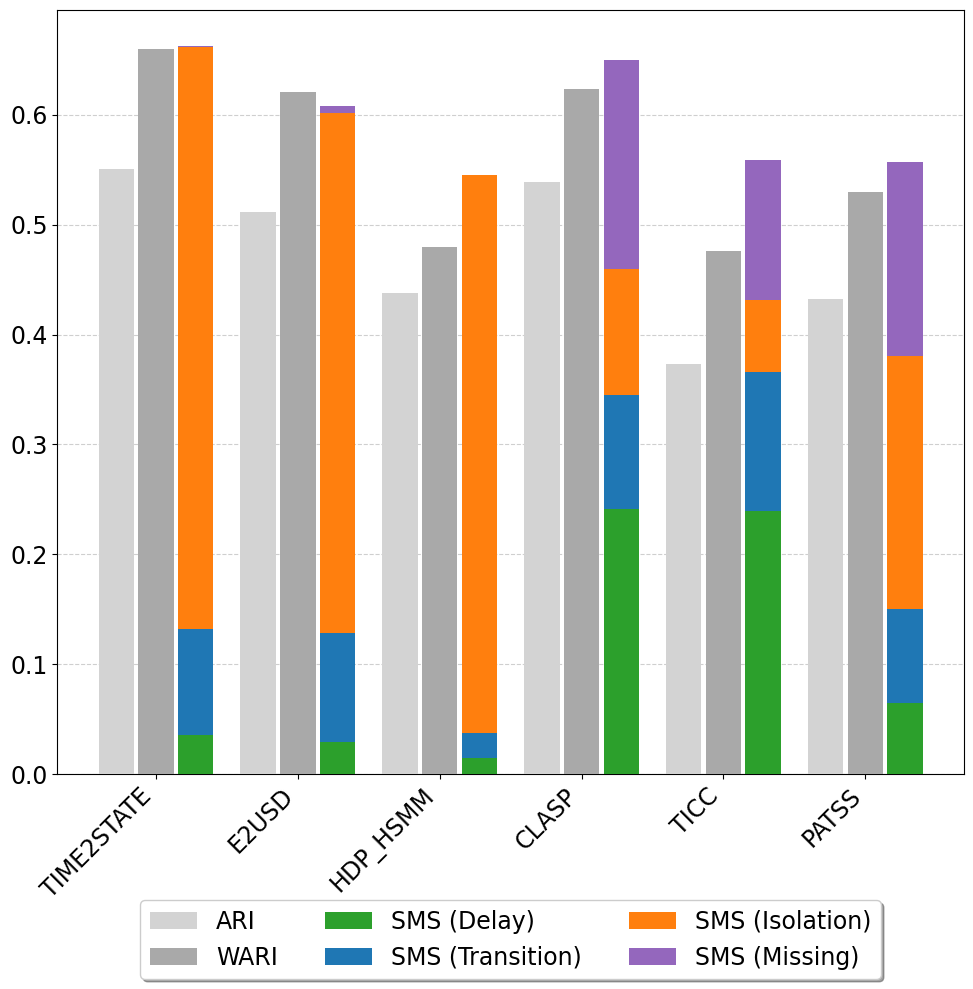

In [32]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

# Ensure current_estimators and current_datasets are available (from CELL 17 or similar)
# Defaulting if not found, but they should be present from previous cells.
current_estimators = ["time2state", "e2usd", "hdp_hsmm", "clasp", "ticc", "patss"] # Example default
current_datasets = ["MoCap", "ActRecTut", "USC-HAD", "UCRSEG", "PAMAP2"] # Example default

# Initialize dictionaries to store aggregated scores
plot_data_agg = {
    algo: {
        'ari_sum': 0, 'ari_count': 0,
        'wari_sum': 0, 'wari_count': 0,
        'avg_sms_score_sum': 0, 'avg_sms_score_count': 0,
        'avg_delay_size_sum': 0, 'avg_delay_size_count': 0,
        'avg_transition_size_sum': 0, 'avg_transition_size_count': 0,
        'avg_isolation_size_sum': 0, 'avg_isolation_size_count': 0,
        'avg_missing_size_sum': 0, 'avg_missing_size_count': 0
    } for algo in current_estimators
}

# 1. Process list_of_dfs (from CELL 16) for ARI and WARI scores
if 'list_of_dfs' in globals():
    for df_item in list_of_dfs:
        algo = df_item['estimator'].iloc[0]
        dataset_name_from_csv = df_item['dataset_csv_name'].iloc[0]

        if algo in current_estimators and dataset_name_from_csv in current_datasets:
            if 'ari' in df_item.columns and not df_item['ari'].empty:
                mean_ari_for_dataset = df_item['ari'].mean()
                if not pd.isna(mean_ari_for_dataset):
                    plot_data_agg[algo]['ari_sum'] += mean_ari_for_dataset
                    plot_data_agg[algo]['ari_count'] += 1
            if 'wari' in df_item.columns and not df_item['wari'].empty:
                mean_wari_for_dataset = df_item['wari'].mean()
                if not pd.isna(mean_wari_for_dataset):
                    plot_data_agg[algo]['wari_sum'] += mean_wari_for_dataset
                    plot_data_agg[algo]['wari_count'] += 1
else:
    print("Warning: 'list_of_dfs' not found. ARI and WARI scores will be missing.")

# 2. Process list_of_dataframes_per_algo (from CELL 17) for SMS scores and error components
if 'list_of_dataframes_per_algo' in globals():
    for df_algo in list_of_dataframes_per_algo:
        algo = df_algo['algorithm'].iloc[0]
        if algo in current_estimators:
            df_algo_filtered = df_algo[df_algo['dataset'].isin(current_datasets)]
            
            if not df_algo_filtered.empty:
                # Summing per-dataset averages; will average them later
                plot_data_agg[algo]['avg_sms_score_sum'] += df_algo_filtered['avg_score'].sum()
                plot_data_agg[algo]['avg_sms_score_count'] += df_algo_filtered['avg_score'].count() # count non-NaNs
                
                plot_data_agg[algo]['avg_delay_size_sum'] += df_algo_filtered['avg_delay_size'].sum()
                plot_data_agg[algo]['avg_delay_size_count'] += df_algo_filtered['avg_delay_size'].count()
                
                plot_data_agg[algo]['avg_transition_size_sum'] += df_algo_filtered['avg_transition_size'].sum()
                plot_data_agg[algo]['avg_transition_size_count'] += df_algo_filtered['avg_transition_size'].count()
                
                plot_data_agg[algo]['avg_isolation_size_sum'] += df_algo_filtered['avg_isolation_size'].sum()
                plot_data_agg[algo]['avg_isolation_size_count'] += df_algo_filtered['avg_isolation_size'].count()
                
                plot_data_agg[algo]['avg_missing_size_sum'] += df_algo_filtered['avg_missing_size'].sum()
                plot_data_agg[algo]['avg_missing_size_count'] += df_algo_filtered['avg_missing_size'].count()
else:
    print("Warning: 'list_of_dataframes_per_algo' not found. SMS scores and breakdown will be missing.")

# 3. Calculate final average scores
final_scores_plotting = {algo: {} for algo in current_estimators}
for algo in current_estimators:
    final_scores_plotting[algo]['ari'] = plot_data_agg[algo]['ari_sum'] / plot_data_agg[algo]['ari_count'] if plot_data_agg[algo]['ari_count'] > 0 else np.nan
    final_scores_plotting[algo]['wari'] = plot_data_agg[algo]['wari_sum'] / plot_data_agg[algo]['wari_count'] if plot_data_agg[algo]['wari_count'] > 0 else np.nan
    
    final_scores_plotting[algo]['sms_score'] = plot_data_agg[algo]['avg_sms_score_sum'] / plot_data_agg[algo]['avg_sms_score_count'] if plot_data_agg[algo]['avg_sms_score_count'] > 0 else np.nan
    final_scores_plotting[algo]['delay_size'] = plot_data_agg[algo]['avg_delay_size_sum'] / plot_data_agg[algo]['avg_delay_size_count'] if plot_data_agg[algo]['avg_delay_size_count'] > 0 else 0
    final_scores_plotting[algo]['transition_size'] = plot_data_agg[algo]['avg_transition_size_sum'] / plot_data_agg[algo]['avg_transition_size_count'] if plot_data_agg[algo]['avg_transition_size_count'] > 0 else 0
    final_scores_plotting[algo]['isolation_size'] = plot_data_agg[algo]['avg_isolation_size_sum'] / plot_data_agg[algo]['avg_isolation_size_count'] if plot_data_agg[algo]['avg_isolation_size_count'] > 0 else 0
    final_scores_plotting[algo]['missing_size'] = plot_data_agg[algo]['avg_missing_size_sum'] / plot_data_agg[algo]['avg_missing_size_count'] if plot_data_agg[algo]['avg_missing_size_count'] > 0 else 0

# 4. Prepare data for plotting
algorithms_plot_order = current_estimators
ari_values = [final_scores_plotting[algo]['ari'] for algo in algorithms_plot_order]
wari_values = [final_scores_plotting[algo]['wari'] for algo in algorithms_plot_order]

sms_delay_contrib = []
sms_transition_contrib = []
sms_isolation_contrib = []
sms_missing_contrib = []

for algo in algorithms_plot_order:
    avg_sms_score_for_algo = final_scores_plotting[algo]['sms_score']
    if pd.isna(avg_sms_score_for_algo):
        avg_sms_score_for_algo = 0.0 # Treat as 0 for plotting if NaN

    s_delay = final_scores_plotting[algo]['delay_size']
    s_transition = final_scores_plotting[algo]['transition_size']
    s_isolation = final_scores_plotting[algo]['isolation_size']
    s_missing = final_scores_plotting[algo]['missing_size']
    
    total_error_size_for_algo = s_delay + s_transition + s_isolation + s_missing
    
    c_delay, c_transition, c_isolation, c_missing = 0.0, 0.0, 0.0, 0.0

    if total_error_size_for_algo > 0:
        p_delay = s_delay / total_error_size_for_algo
        p_transition = s_transition / total_error_size_for_algo
        p_isolation = s_isolation / total_error_size_for_algo
        p_missing = 1.0 - (p_delay + p_transition + p_isolation) # Ensure sum of p_ is 1

        c_delay = p_delay * avg_sms_score_for_algo
        c_transition = p_transition * avg_sms_score_for_algo
        c_isolation = p_isolation * avg_sms_score_for_algo
        c_missing = p_missing * avg_sms_score_for_algo
        
        # Ensure sum of components equals avg_sms_score_for_algo and non-negative
        # (simple clamping for robustness, more sophisticated normalization could be used)
        current_total_contrib = c_delay + c_transition + c_isolation + c_missing
        if abs(current_total_contrib - avg_sms_score_for_algo) > 1e-9 and current_total_contrib != 0 : # if sum is off and not zero
            factor = avg_sms_score_for_algo / current_total_contrib
            c_delay *= factor
            c_transition *= factor
            c_isolation *= factor
            c_missing *= factor
        
        # Final adjustment for the last component to hit the target sum precisely
        c_sum_first_three = c_delay + c_transition + c_isolation
        c_missing = avg_sms_score_for_algo - c_sum_first_three


    elif avg_sms_score_for_algo > 0: # total_error_size is 0, but SMS score is positive
        c_delay = avg_sms_score_for_algo # Assign full score to the first component
    
    # Ensure non-negativity after all adjustments
    sms_delay_contrib.append(max(0, c_delay))
    sms_transition_contrib.append(max(0, c_transition))
    sms_isolation_contrib.append(max(0, c_isolation))
    sms_missing_contrib.append(max(0, c_missing))

# 5. Plotting
num_algos = len(algorithms_plot_order)
x_indices = np.arange(num_algos)
bar_width = 0.28 # This variable determines the offset of bar centers for ARI and SMS from WARI

fig, ax = plt.subplots(figsize=(max(10, num_algos * 2), 10)) # Dynamic width

# ARI and WARI bars
# Use 'plotted_bar_width' (from context, expected value 0.25) for the actual width of the bars.
# 'bar_width' (0.28, defined above) is used for positioning the centers.
plotted_bar_width = 0.25
ax.bar(x_indices - bar_width, ari_values, plotted_bar_width, label='ARI', color='lightgrey', zorder=3)
ax.bar(x_indices, wari_values, plotted_bar_width, label='WARI', color='darkgrey', zorder=3)

# SMS stacked bars
sms_c_delay = np.array(sms_delay_contrib)
sms_c_transition = np.array(sms_transition_contrib)
sms_c_isolation = np.array(sms_isolation_contrib)
sms_c_missing = np.array(sms_missing_contrib)

bottom_tr = sms_c_delay
bottom_is = sms_c_delay + sms_c_transition
bottom_mi = sms_c_delay + sms_c_transition + sms_c_isolation

# Use 'plotted_bar_width' for the actual width of the bars for SMS components as well.
ax.bar(x_indices + bar_width, sms_c_delay, plotted_bar_width, label='SMS (Delay)', color='tab:green', zorder=3)
ax.bar(x_indices + bar_width, sms_c_transition, plotted_bar_width, bottom=bottom_tr, label='SMS (Transition)', color='tab:blue', zorder=3)
ax.bar(x_indices + bar_width, sms_c_isolation, plotted_bar_width, bottom=bottom_is, label='SMS (Isolation)', color='tab:orange', zorder=3)
ax.bar(x_indices + bar_width, sms_c_missing, plotted_bar_width, bottom=bottom_mi, label='SMS (Missing)', color='tab:purple', zorder=3)


#ax.set_xlabel('Algorithms', fontsize=12)
#ax.set_ylabel('Average Score / Proportional Contribution', fontsize=12)
#ax.set_title('Algorithm Performance Comparison (Avg. over Selected Datasets)', fontsize=14)
ax.set_xticks(x_indices)
ax.set_xticklabels([algo.upper() for algo in algorithms_plot_order], rotation=45, ha="right", fontsize=17)
ax.tick_params(axis='y', labelsize=17) # Increased y-axis tick label size
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3, fontsize=17)
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.set_ylim(bottom=0) # Ensure y-axis starts at 0, can adjust if scores can be negative
figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
file_path = os.path.join(figures_dir, "global_scores_ari_wari_sms.pdf")

plt.tight_layout(rect=[0, 0, 0.82, 1]) # Adjust layout to make space for legend
#plt.savefig(file_path, bbox_inches='tight')
plt.show()

## Scores across datasets (error)

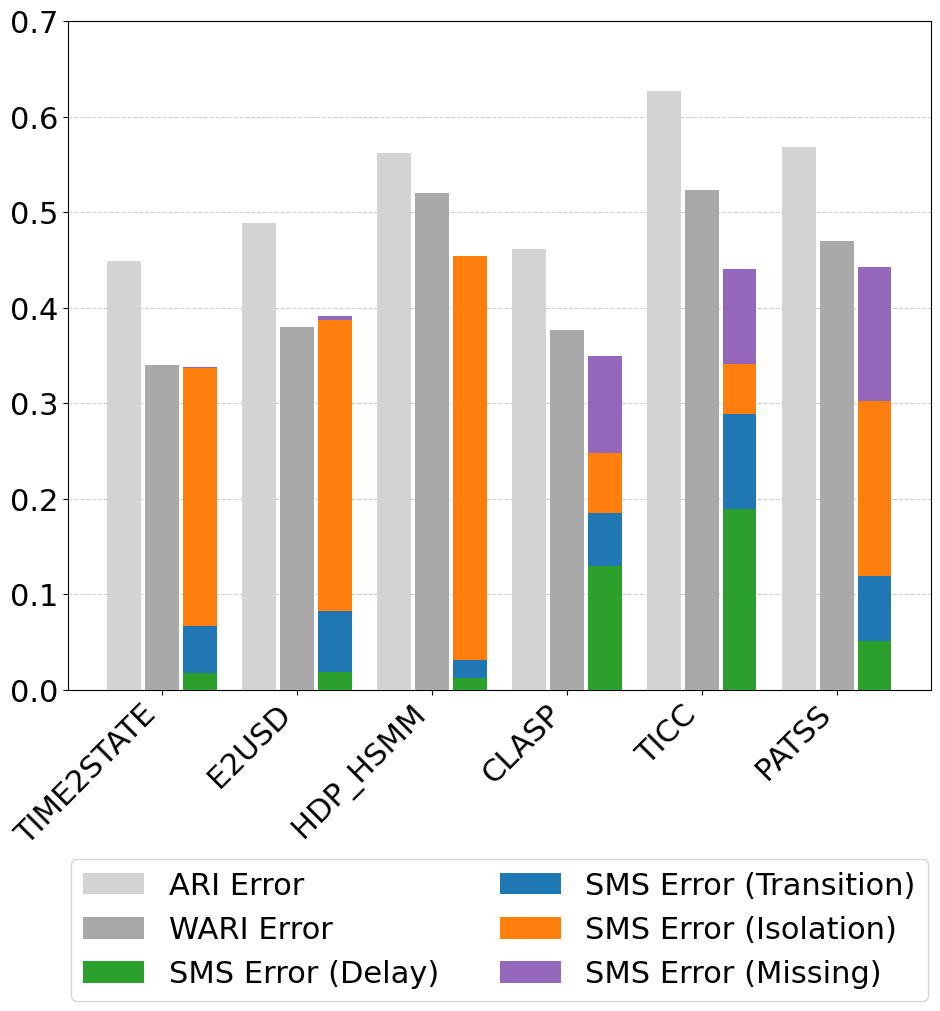

In [80]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

# Ensure current_estimators and current_datasets are available (from CELL 17 or similar)
# Defaulting if not found, but they should be present from previous cells.
current_estimators = ["time2state", "e2usd", "hdp_hsmm", "clasp", "ticc", "patss"] # Example default
current_datasets = ["MoCap", "ActRecTut", "USC-HAD", "UCRSEG", "PAMAP2"] # Example default

# Initialize dictionaries to store aggregated scores
plot_data_agg = {
    algo: {
        'ari_sum': 0, 'ari_count': 0,
        'wari_sum': 0, 'wari_count': 0,
        'avg_sms_score_sum': 0, 'avg_sms_score_count': 0,
        'avg_delay_size_sum': 0, 'avg_delay_size_count': 0,
        'avg_transition_size_sum': 0, 'avg_transition_size_count': 0,
        'avg_isolation_size_sum': 0, 'avg_isolation_size_count': 0,
        'avg_missing_size_sum': 0, 'avg_missing_size_count': 0
    } for algo in current_estimators
}

# 1. Process list_of_dfs (from CELL 16) for ARI and WARI scores
if 'list_of_dfs' in globals():
    for df_item in list_of_dfs:
        algo = df_item['estimator'].iloc[0]
        dataset_name_from_csv = df_item['dataset_csv_name'].iloc[0]

        if algo in current_estimators and dataset_name_from_csv in current_datasets:
            if 'ari' in df_item.columns and not df_item['ari'].empty:
                mean_ari_for_dataset = df_item['ari'].mean()
                if not pd.isna(mean_ari_for_dataset):
                    plot_data_agg[algo]['ari_sum'] += mean_ari_for_dataset
                    plot_data_agg[algo]['ari_count'] += 1
            if 'wari' in df_item.columns and not df_item['wari'].empty:
                mean_wari_for_dataset = df_item['wari'].mean()
                if not pd.isna(mean_wari_for_dataset):
                    plot_data_agg[algo]['wari_sum'] += mean_wari_for_dataset
                    plot_data_agg[algo]['wari_count'] += 1
else:
    print("Warning: 'list_of_dfs' not found. ARI and WARI scores will be missing.")

# 2. Process list_of_dataframes_per_algo (from CELL 17) for SMS scores and error components
if 'list_of_dataframes_per_algo' in globals():
    for df_algo in list_of_dataframes_per_algo:
        algo = df_algo['algorithm'].iloc[0]
        if algo in current_estimators:
            df_algo_filtered = df_algo[df_algo['dataset'].isin(current_datasets)]
            
            if not df_algo_filtered.empty:
                # Summing per-dataset averages; will average them later
                plot_data_agg[algo]['avg_sms_score_sum'] += df_algo_filtered['avg_score'].sum()
                plot_data_agg[algo]['avg_sms_score_count'] += df_algo_filtered['avg_score'].count() # count non-NaNs
                
                plot_data_agg[algo]['avg_delay_size_sum'] += df_algo_filtered['avg_delay_size'].sum()
                plot_data_agg[algo]['avg_delay_size_count'] += df_algo_filtered['avg_delay_size'].count()
                
                plot_data_agg[algo]['avg_transition_size_sum'] += df_algo_filtered['avg_transition_size'].sum()
                plot_data_agg[algo]['avg_transition_size_count'] += df_algo_filtered['avg_transition_size'].count()
                
                plot_data_agg[algo]['avg_isolation_size_sum'] += df_algo_filtered['avg_isolation_size'].sum()
                plot_data_agg[algo]['avg_isolation_size_count'] += df_algo_filtered['avg_isolation_size'].count()
                
                plot_data_agg[algo]['avg_missing_size_sum'] += df_algo_filtered['avg_missing_size'].sum()
                plot_data_agg[algo]['avg_missing_size_count'] += df_algo_filtered['avg_missing_size'].count()
else:
    print("Warning: 'list_of_dataframes_per_algo' not found. SMS scores and breakdown will be missing.")

# 3. Calculate final average scores
final_scores_plotting = {algo: {} for algo in current_estimators}
for algo in current_estimators:
    final_scores_plotting[algo]['ari'] = plot_data_agg[algo]['ari_sum'] / plot_data_agg[algo]['ari_count'] if plot_data_agg[algo]['ari_count'] > 0 else np.nan
    final_scores_plotting[algo]['wari'] = plot_data_agg[algo]['wari_sum'] / plot_data_agg[algo]['wari_count'] if plot_data_agg[algo]['wari_count'] > 0 else np.nan
    
    final_scores_plotting[algo]['sms_score'] = plot_data_agg[algo]['avg_sms_score_sum'] / plot_data_agg[algo]['avg_sms_score_count'] if plot_data_agg[algo]['avg_sms_score_count'] > 0 else np.nan
    final_scores_plotting[algo]['delay_size'] = plot_data_agg[algo]['avg_delay_size_sum'] / plot_data_agg[algo]['avg_delay_size_count'] if plot_data_agg[algo]['avg_delay_size_count'] > 0 else 0
    final_scores_plotting[algo]['transition_size'] = plot_data_agg[algo]['avg_transition_size_sum'] / plot_data_agg[algo]['avg_transition_size_count'] if plot_data_agg[algo]['avg_transition_size_count'] > 0 else 0
    final_scores_plotting[algo]['isolation_size'] = plot_data_agg[algo]['avg_isolation_size_sum'] / plot_data_agg[algo]['avg_isolation_size_count'] if plot_data_agg[algo]['avg_isolation_size_count'] > 0 else 0
    final_scores_plotting[algo]['missing_size'] = plot_data_agg[algo]['avg_missing_size_sum'] / plot_data_agg[algo]['avg_missing_size_count'] if plot_data_agg[algo]['avg_missing_size_count'] > 0 else 0

# 4. Prepare data for plotting (Error View: 1 - Score)
algorithms_plot_order = current_estimators

# Calculate ARI and WARI errors (1 - score)
ari_scores_raw = np.array([final_scores_plotting[algo]['ari'] for algo in algorithms_plot_order], dtype=float)
ari_values = np.where(np.isnan(ari_scores_raw), 1.0, 1.0 - ari_scores_raw).tolist() # NaN score -> 1.0 error

wari_scores_raw = np.array([final_scores_plotting[algo]['wari'] for algo in algorithms_plot_order], dtype=float)
wari_values = np.where(np.isnan(wari_scores_raw), 1.0, 1.0 - wari_scores_raw).tolist() # NaN score -> 1.0 error


sms_delay_contrib = []
sms_transition_contrib = []
sms_isolation_contrib = []
sms_missing_contrib = []

for algo in algorithms_plot_order:
    original_sms_score = final_scores_plotting[algo]['sms_score']
    
    if pd.isna(original_sms_score):
        target_total_sms_error = 1.0 # If original score is NaN, error is 1.0
    else:
        target_total_sms_error = 1.0 - original_sms_score

    s_delay = final_scores_plotting[algo]['delay_size']
    s_transition = final_scores_plotting[algo]['transition_size']
    s_isolation = final_scores_plotting[algo]['isolation_size']
    s_missing = final_scores_plotting[algo]['missing_size']
    
    total_error_size_for_algo = s_delay + s_transition + s_isolation + s_missing
    
    c_delay, c_transition, c_isolation, c_missing = 0.0, 0.0, 0.0, 0.0

    if total_error_size_for_algo > 0:
        # Proportions of error types based on their sizes
        p_delay = s_delay / total_error_size_for_algo
        p_transition = s_transition / total_error_size_for_algo
        p_isolation = s_isolation / total_error_size_for_algo
        # p_missing is calculated to make proportions sum to 1.0
        p_missing = 1.0 - (p_delay + p_transition + p_isolation) 

        # Distribute the target_total_sms_error according to these proportions
        c_delay = p_delay * target_total_sms_error
        c_transition = p_transition * target_total_sms_error
        c_isolation = p_isolation * target_total_sms_error
        c_missing = p_missing * target_total_sms_error
        
        # Normalization to ensure components sum exactly to target_total_sms_error
        current_total_contrib = c_delay + c_transition + c_isolation + c_missing
        if abs(current_total_contrib - target_total_sms_error) > 1e-9 and current_total_contrib != 0 : 
            factor = target_total_sms_error / current_total_contrib
            c_delay *= factor
            c_transition *= factor
            c_isolation *= factor
            c_missing *= factor
        
        # Final adjustment for the last component to hit the target sum precisely
        c_sum_first_three = c_delay + c_transition + c_isolation
        c_missing = target_total_sms_error - c_sum_first_three

    elif target_total_sms_error > 0: # total_error_size_for_algo is 0, but there's an overall error
        c_delay = target_total_sms_error # Assign full error to the first component by convention
    
    # Ensure non-negativity after all adjustments
    sms_delay_contrib.append(max(0, c_delay))
    sms_transition_contrib.append(max(0, c_transition))
    sms_isolation_contrib.append(max(0, c_isolation))
    sms_missing_contrib.append(max(0, c_missing))

# 5. Plotting
num_algos = len(algorithms_plot_order)
x_indices = np.arange(num_algos)
bar_width = 0.28 
plotted_bar_width = 0.25

#fig, ax = plt.subplots(figsize=(max(10, num_algos * 2), 12))
fig, ax = plt.subplots(figsize=(10, 12)) 

# ARI and WARI Error bars
ax.bar(x_indices - bar_width, ari_values, plotted_bar_width, label='ARI Error', color='lightgrey', zorder=3)
ax.bar(x_indices, wari_values, plotted_bar_width, label='WARI Error', color='darkgrey', zorder=3)

# SMS Error stacked bars
sms_c_delay = np.array(sms_delay_contrib)
sms_c_transition = np.array(sms_transition_contrib)
sms_c_isolation = np.array(sms_isolation_contrib)
sms_c_missing = np.array(sms_missing_contrib)

bottom_tr = sms_c_delay
bottom_is = sms_c_delay + sms_c_transition
bottom_mi = sms_c_delay + sms_c_transition + sms_c_isolation

ax.bar(x_indices + bar_width, sms_c_delay, plotted_bar_width, label='SMS Error (Delay)', color='tab:green', zorder=3)
ax.bar(x_indices + bar_width, sms_c_transition, plotted_bar_width, bottom=bottom_tr, label='SMS Error (Transition)', color='tab:blue', zorder=3)
ax.bar(x_indices + bar_width, sms_c_isolation, plotted_bar_width, bottom=bottom_is, label='SMS Error (Isolation)', color='tab:orange', zorder=3)
ax.bar(x_indices + bar_width, sms_c_missing, plotted_bar_width, bottom=bottom_mi, label='SMS Error (Missing)', color='tab:purple', zorder=3)


#ax.set_xlabel('Algorithms', fontsize=12) # Usually not needed if xticklabels are clear
#ax.set_ylabel('Average Error / Proportional Contribution', fontsize=17) # Updated Y-axis label
#ax.set_title('Algorithm Performance Comparison (Avg. Error over Selected Datasets)', fontsize=14) # Updated Title
ax.set_xticks(x_indices)
ax.set_xticklabels([algo.upper() for algo in algorithms_plot_order], rotation=45, ha="right", fontsize=22)
ax.tick_params(axis='y', labelsize=22) 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.23), fancybox=True, shadow=False, ncol=2, fontsize=22) # Adjust the value in bbox_to_anchor to control vertical spacing
ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0)
ax.set_ylim(bottom=0, top=0.7) # Ensure y-axis starts at 0 and accommodates errors up to 1.0 (or slightly above for visual)

figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
file_path = os.path.join(figures_dir, "global_errors_ari_wari_sms.pdf") # Updated filename

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout; may need tuning for new legend/labels
plt.savefig(file_path, bbox_inches='tight')
plt.show()

## Scores per dataset (accuracy)

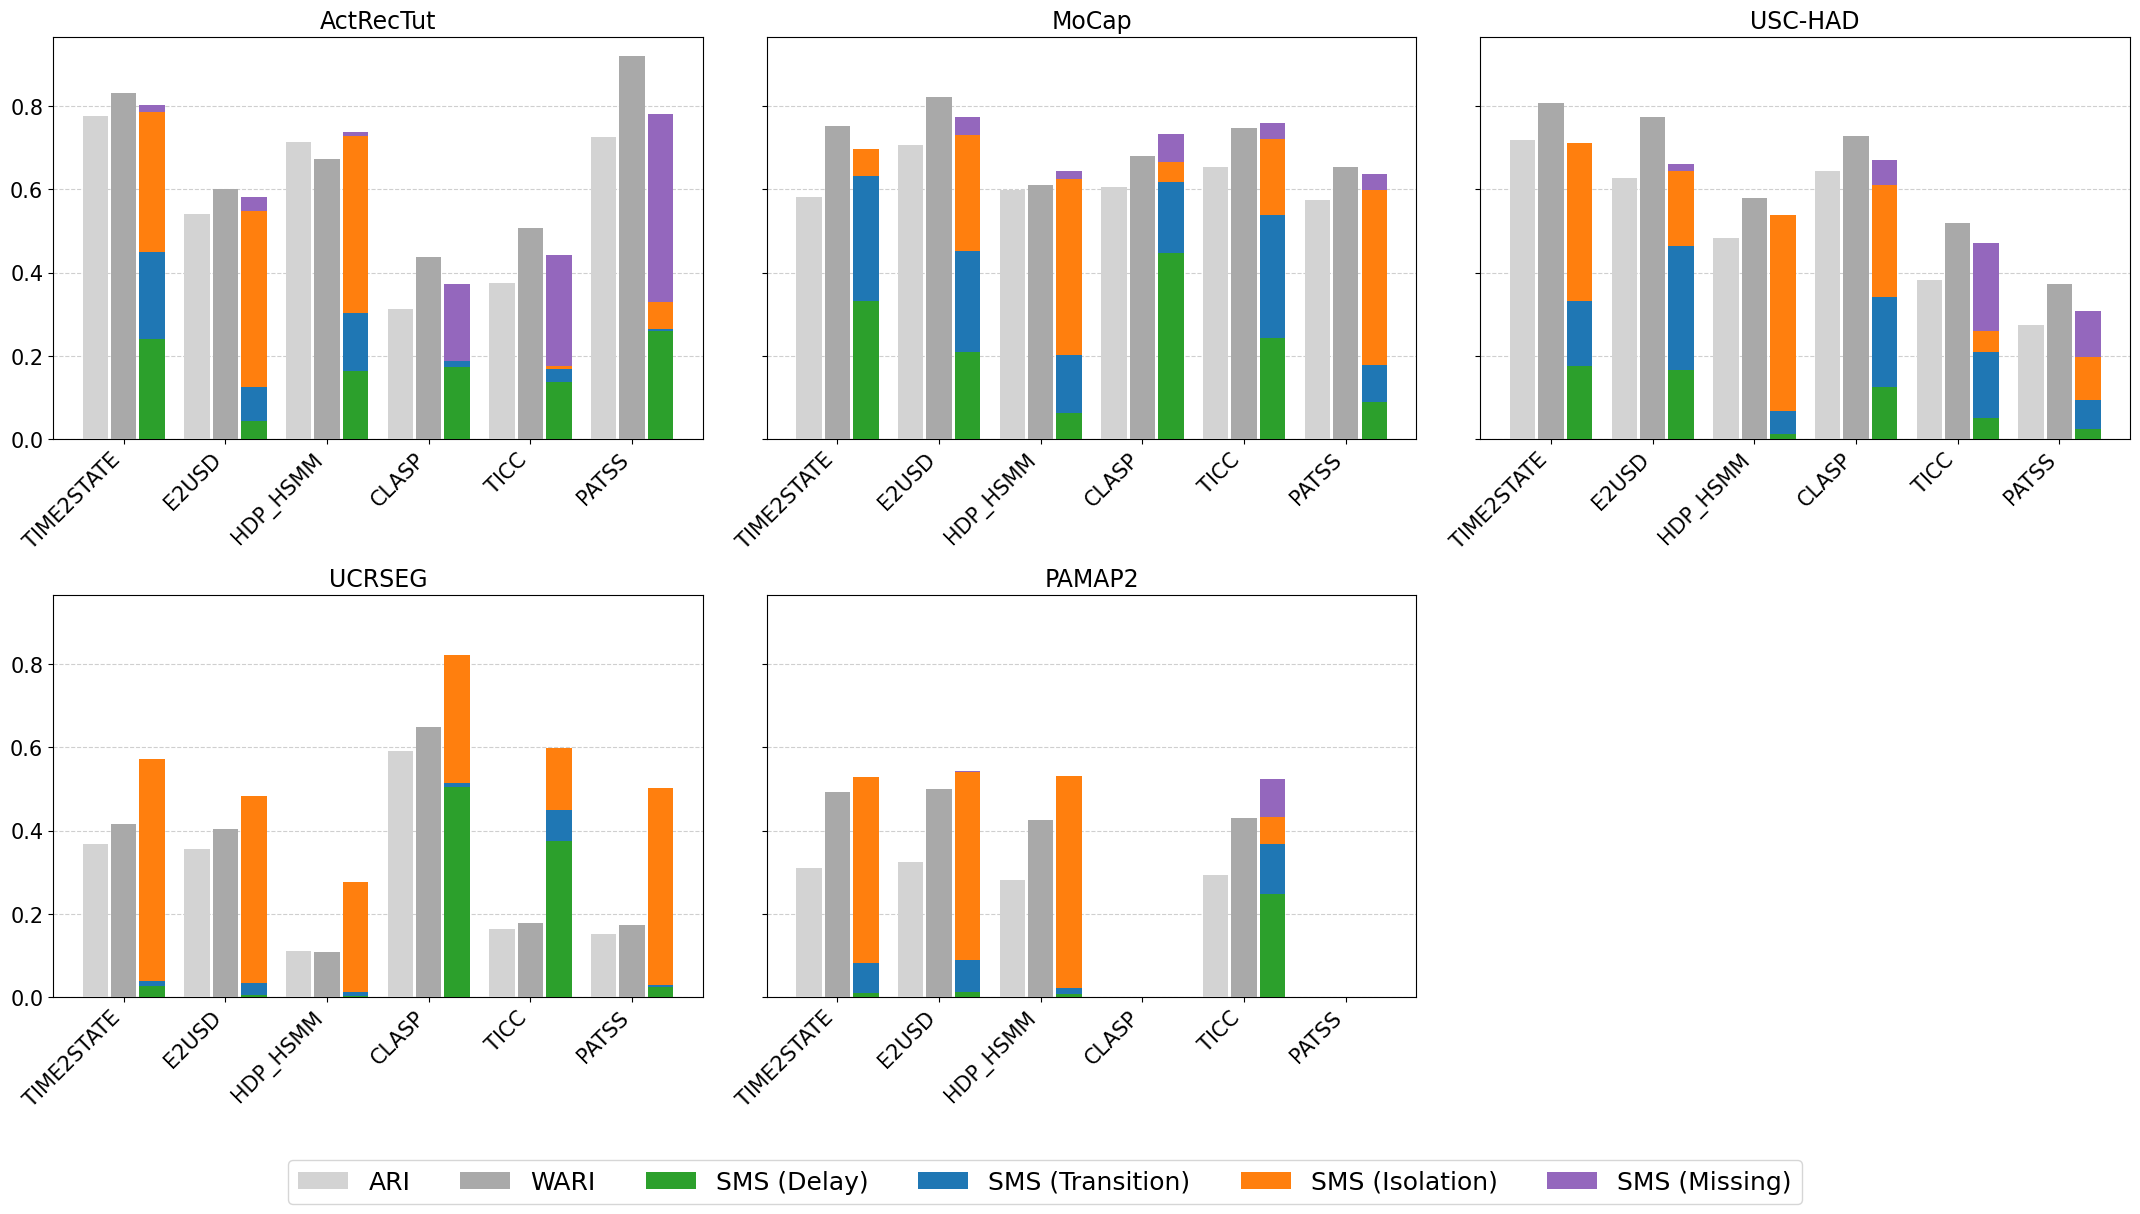

In [20]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

# These lists should be defined, e.g., from your existing notebook context
# Example values if not already defined:
if 'current_estimators' not in globals():
    current_estimators = ["time2state", "e2usd", "hdp_hsmm", "clasp", "ticc", "patss"]
if 'current_datasets' not in globals():
    current_datasets = ["MoCap", "ActRecTut", "USC-HAD", "UCRSEG", "PAMAP2"]

# Define the order for plotting datasets
plot_order_datasets = ["ActRecTut", "MoCap", "USC-HAD", "UCRSEG", "PAMAP2"]

# Initialize dictionary to store per-dataset scores
# It's initialized based on current_datasets to capture all data,
# then plot_order_datasets controls the plotting.
plot_data_per_dataset = {
    ds: {
        algo: {
            'ari': np.nan, 'wari': np.nan,
            'sms_score': np.nan,
            'delay_size': 0.0, 'transition_size': 0.0,
            'isolation_size': 0.0, 'missing_size': 0.0
        } for algo in current_estimators
    } for ds in current_datasets # Use all available datasets for data collection
}

# 1. Process list_of_dfs (from CELL 16) for ARI and WARI scores
if 'list_of_dfs' in globals() and isinstance(list_of_dfs, list):
    for df_item in list_of_dfs:
        if not isinstance(df_item, pd.DataFrame) or df_item.empty:
            continue
        algo = df_item['estimator'].iloc[0]
        dataset_name_from_csv = df_item['dataset_csv_name'].iloc[0]

        if algo in current_estimators and dataset_name_from_csv in plot_data_per_dataset:
            if 'ari' in df_item.columns and not df_item['ari'].empty:
                mean_ari_for_dataset = df_item['ari'].mean()
                if not pd.isna(mean_ari_for_dataset):
                    plot_data_per_dataset[dataset_name_from_csv][algo]['ari'] = mean_ari_for_dataset
            if 'wari' in df_item.columns and not df_item['wari'].empty:
                mean_wari_for_dataset = df_item['wari'].mean()
                if not pd.isna(mean_wari_for_dataset):
                    plot_data_per_dataset[dataset_name_from_csv][algo]['wari'] = mean_wari_for_dataset
else:
    print("Warning: 'list_of_dfs' not found or is not a list. ARI and WARI scores might be missing or incomplete.")

# 2. Process list_of_dataframes_per_algo (from CELL 17) for SMS scores and error components
if 'list_of_dataframes_per_algo' in globals() and isinstance(list_of_dataframes_per_algo, list):
    for df_algo_all_datasets in list_of_dataframes_per_algo:
        if not isinstance(df_algo_all_datasets, pd.DataFrame) or df_algo_all_datasets.empty:
            continue
        
        # Check if 'algorithm' column exists and is not empty
        if 'algorithm' not in df_algo_all_datasets.columns or df_algo_all_datasets['algorithm'].empty:
            continue
        algo = df_algo_all_datasets['algorithm'].iloc[0]

        if algo in current_estimators:
            for _, row in df_algo_all_datasets.iterrows():
                if 'dataset' not in row:
                    continue
                dataset_name = row['dataset']
                if dataset_name in plot_data_per_dataset:
                    plot_data_per_dataset[dataset_name][algo]['sms_score'] = row['avg_score'] if 'avg_score' in row and not pd.isna(row['avg_score']) else np.nan
                    plot_data_per_dataset[dataset_name][algo]['delay_size'] = row['avg_delay_size'] if 'avg_delay_size' in row and not pd.isna(row['avg_delay_size']) else 0.0
                    plot_data_per_dataset[dataset_name][algo]['transition_size'] = row['avg_transition_size'] if 'avg_transition_size' in row and not pd.isna(row['avg_transition_size']) else 0.0
                    plot_data_per_dataset[dataset_name][algo]['isolation_size'] = row['avg_isolation_size'] if 'avg_isolation_size' in row and not pd.isna(row['avg_isolation_size']) else 0.0
                    plot_data_per_dataset[dataset_name][algo]['missing_size'] = row['avg_missing_size'] if 'avg_missing_size' in row and not pd.isna(row['avg_missing_size']) else 0.0
else:
    print("Warning: 'list_of_dataframes_per_algo' not found or is not a list. SMS scores and breakdown might be missing or incomplete.")

# 4. & 5. Plotting per dataset
algorithms_plot_order = current_estimators
num_algos = len(algorithms_plot_order)
x_indices = np.arange(num_algos)
bar_width = 0.28 
plotted_bar_width = 0.25

fig, axs = plt.subplots(2, 3, figsize=(22, 13), sharey=True)
axs_flat = axs.flatten()

for i, dataset_name in enumerate(plot_order_datasets):
    ax = axs_flat[i]
    
    if dataset_name not in plot_data_per_dataset:
        ax.set_title(f"{dataset_name}\n(Data not available)", fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        continue

    ari_values = [plot_data_per_dataset[dataset_name][algo].get('ari', np.nan) for algo in algorithms_plot_order]
    wari_values = [plot_data_per_dataset[dataset_name][algo].get('wari', np.nan) for algo in algorithms_plot_order]

    sms_delay_contrib = []
    sms_transition_contrib = []
    sms_isolation_contrib = []
    sms_missing_contrib = []

    for algo in algorithms_plot_order:
        algo_data = plot_data_per_dataset[dataset_name][algo]
        avg_sms_score_for_algo = algo_data.get('sms_score', np.nan)
        
        s_delay = algo_data.get('delay_size', 0.0)
        s_transition = algo_data.get('transition_size', 0.0)
        s_isolation = algo_data.get('isolation_size', 0.0)
        s_missing = algo_data.get('missing_size', 0.0)
        
        c_delay, c_transition, c_isolation, c_missing = 0.0, 0.0, 0.0, 0.0

        if pd.isna(avg_sms_score_for_algo):
            avg_sms_score_for_algo = 0.0 # Treat NaN score as 0 for contribution calculation

        total_error_size_for_algo = s_delay + s_transition + s_isolation + s_missing

        if total_error_size_for_algo > 1e-9: # Check against a small epsilon
            p_delay = s_delay / total_error_size_for_algo
            p_transition = s_transition / total_error_size_for_algo
            p_isolation = s_isolation / total_error_size_for_algo
            
            p_sum_first_three = p_delay + p_transition + p_isolation
            if p_sum_first_three > 1.0:
                norm_factor = p_sum_first_three
                p_delay /= norm_factor
                p_transition /= norm_factor
                p_isolation /= norm_factor
                p_missing = 0.0
            else:
                p_missing = 1.0 - p_sum_first_three

            c_delay = p_delay * avg_sms_score_for_algo
            c_transition = p_transition * avg_sms_score_for_algo
            c_isolation = p_isolation * avg_sms_score_for_algo
            c_missing = p_missing * avg_sms_score_for_algo
            
            current_total_contrib = c_delay + c_transition + c_isolation + c_missing
            if avg_sms_score_for_algo > 1e-9 and abs(current_total_contrib - avg_sms_score_for_algo) > 1e-9:
                if current_total_contrib != 0:
                    factor = avg_sms_score_for_algo / current_total_contrib
                    c_delay *= factor
                    c_transition *= factor
                    c_isolation *= factor
            
            c_sum_first_three_adj = c_delay + c_transition + c_isolation
            c_missing = avg_sms_score_for_algo - c_sum_first_three_adj

        elif avg_sms_score_for_algo > 0:
            c_delay = avg_sms_score_for_algo
        
        sms_delay_contrib.append(max(0, c_delay))
        sms_transition_contrib.append(max(0, c_transition))
        sms_isolation_contrib.append(max(0, c_isolation))
        sms_missing_contrib.append(max(0, c_missing))

    ax.bar(x_indices - bar_width, ari_values, plotted_bar_width, label='ARI' if i == 0 else "", color='lightgrey', zorder=3)
    ax.bar(x_indices, wari_values, plotted_bar_width, label='WARI' if i == 0 else "", color='darkgrey', zorder=3)

    sms_c_delay = np.array(sms_delay_contrib)
    sms_c_transition = np.array(sms_transition_contrib)
    sms_c_isolation = np.array(sms_isolation_contrib)
    sms_c_missing = np.array(sms_missing_contrib)

    bottom_tr = sms_c_delay
    bottom_is = sms_c_delay + sms_c_transition
    bottom_mi = sms_c_delay + sms_c_transition + sms_c_isolation

    ax.bar(x_indices + bar_width, sms_c_delay, plotted_bar_width, label='SMS (Delay)' if i == 0 else "", color='tab:green', zorder=3)
    ax.bar(x_indices + bar_width, sms_c_transition, plotted_bar_width, bottom=bottom_tr, label='SMS (Transition)' if i == 0 else "", color='tab:blue', zorder=3)
    ax.bar(x_indices + bar_width, sms_c_isolation, plotted_bar_width, bottom=bottom_is, label='SMS (Isolation)' if i == 0 else "", color='tab:orange', zorder=3)
    ax.bar(x_indices + bar_width, sms_c_missing, plotted_bar_width, bottom=bottom_mi, label='SMS (Missing)' if i == 0 else "", color='tab:purple', zorder=3)

    ax.set_title(dataset_name, fontsize=17)
    ax.set_xticks(x_indices)
    ax.set_xticklabels([algo.upper() for algo in algorithms_plot_order], rotation=45, ha="right", fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0)
    ax.set_ylim(bottom=0) # Ensure y-axis starts at 0 for each subplot

# Hide unused subplots
if len(plot_order_datasets) < len(axs_flat):
    for j in range(len(plot_order_datasets), len(axs_flat)):
        axs_flat[j].set_visible(False)

# Common Y-axis label
#fig.text(-0.00, 0.5, 'Score / Proportional Contribution', va='center', rotation='vertical', fontsize=18)

# Legend
handles, labels = axs_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=6, fontsize=18)

plt.tight_layout(rect=[0.02, 0.08, 1, 0.95]) # Adjust rect for common Y label and legend

figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
file_path = os.path.join(figures_dir, "per_dataset_scores_ari_wari_sms.pdf")

#plt.savefig(file_path) # bbox_inches='tight' can be added if needed, but tight_layout often suffices
plt.show()


## Scores on a subset of relevant datasets (error)

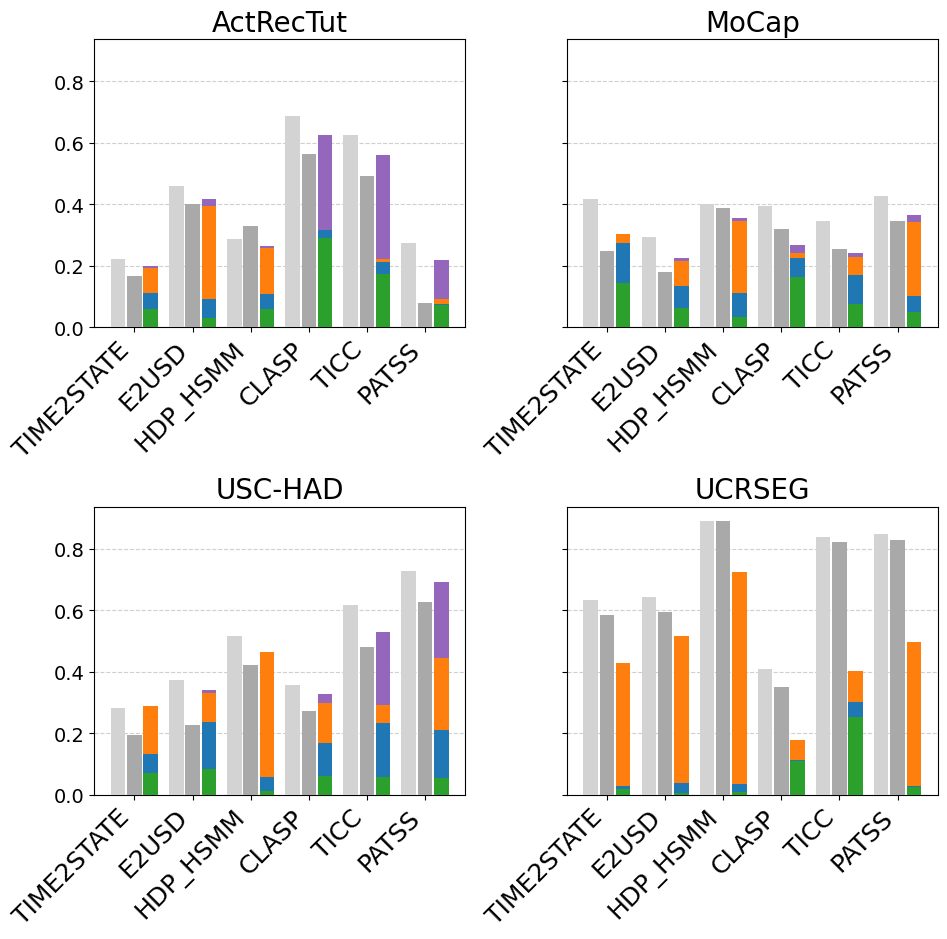

In [87]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

# These lists should be defined, e.g., from your existing notebook context
# Example values if not already defined:
if 'current_estimators' not in globals():
    current_estimators = ["time2state", "e2usd", "hdp_hsmm", "clasp", "ticc", "patss"]
if 'current_datasets' not in globals():
    current_datasets = ["MoCap", "ActRecTut", "USC-HAD", "UCRSEG"]

# Define the order for plotting datasets
plot_order_datasets = ["ActRecTut", "MoCap", "USC-HAD", "UCRSEG"]

# Initialize dictionary to store per-dataset scores
# It's initialized based on current_datasets to capture all data,
# then plot_order_datasets controls the plotting.
plot_data_per_dataset = {
    ds: {
        algo: {
            'ari': np.nan, 'wari': np.nan,
            'sms_score': np.nan,
            'delay_size': 0.0, 'transition_size': 0.0,
            'isolation_size': 0.0, 'missing_size': 0.0
        } for algo in current_estimators
    } for ds in current_datasets # Use all available datasets for data collection
}

# 1. Process list_of_dfs (from CELL 16) for ARI and WARI scores
if 'list_of_dfs' in globals() and isinstance(list_of_dfs, list):
    for df_item in list_of_dfs:
        if not isinstance(df_item, pd.DataFrame) or df_item.empty:
            continue
        algo = df_item['estimator'].iloc[0]
        dataset_name_from_csv = df_item['dataset_csv_name'].iloc[0]

        if algo in current_estimators and dataset_name_from_csv in plot_data_per_dataset:
            if 'ari' in df_item.columns and not df_item['ari'].empty:
                mean_ari_for_dataset = df_item['ari'].mean()
                if not pd.isna(mean_ari_for_dataset):
                    plot_data_per_dataset[dataset_name_from_csv][algo]['ari'] = mean_ari_for_dataset
            if 'wari' in df_item.columns and not df_item['wari'].empty:
                mean_wari_for_dataset = df_item['wari'].mean()
                if not pd.isna(mean_wari_for_dataset):
                    plot_data_per_dataset[dataset_name_from_csv][algo]['wari'] = mean_wari_for_dataset
else:
    print("Warning: 'list_of_dfs' not found or is not a list. ARI and WARI scores might be missing or incomplete.")

# 2. Process list_of_dataframes_per_algo (from CELL 17) for SMS scores and error components
if 'list_of_dataframes_per_algo' in globals() and isinstance(list_of_dataframes_per_algo, list):
    for df_algo_all_datasets in list_of_dataframes_per_algo:
        if not isinstance(df_algo_all_datasets, pd.DataFrame) or df_algo_all_datasets.empty:
            continue
        
        if 'algorithm' not in df_algo_all_datasets.columns or df_algo_all_datasets['algorithm'].empty:
            continue
        algo = df_algo_all_datasets['algorithm'].iloc[0]

        if algo in current_estimators:
            for _, row in df_algo_all_datasets.iterrows():
                if 'dataset' not in row:
                    continue
                dataset_name = row['dataset']
                if dataset_name in plot_data_per_dataset:
                    plot_data_per_dataset[dataset_name][algo]['sms_score'] = row['avg_score'] if 'avg_score' in row and not pd.isna(row['avg_score']) else np.nan
                    plot_data_per_dataset[dataset_name][algo]['delay_size'] = row['avg_delay_size'] if 'avg_delay_size' in row and not pd.isna(row['avg_delay_size']) else 0.0
                    plot_data_per_dataset[dataset_name][algo]['transition_size'] = row['avg_transition_size'] if 'avg_transition_size' in row and not pd.isna(row['avg_transition_size']) else 0.0
                    plot_data_per_dataset[dataset_name][algo]['isolation_size'] = row['avg_isolation_size'] if 'avg_isolation_size' in row and not pd.isna(row['avg_isolation_size']) else 0.0
                    plot_data_per_dataset[dataset_name][algo]['missing_size'] = row['avg_missing_size'] if 'avg_missing_size' in row and not pd.isna(row['avg_missing_size']) else 0.0
else:
    print("Warning: 'list_of_dataframes_per_algo' not found or is not a list. SMS scores and breakdown might be missing or incomplete.")

# Helper function to add labels to bars
def add_labels_to_bars(ax, bars_container, values_for_labels):
    for i, bar in enumerate(bars_container):
        value = values_for_labels[i]
        # Only add label if value is not NaN and significant enough (e.g. > 0.001 or < -0.001)
        if pd.notna(value) and abs(value) > 1e-3:
            height = bar.get_height()
            y_pos = bar.get_y() + height # Position text at the end of the bar/segment
            
            va_align = 'bottom' if height >= 0 else 'top'
            
            # Small fixed offset for tiny positive bars starting at y=0
            if 0 <= height < 0.015 and bar.get_y() == 0: # Check if bar is positive, small, and starts at 0
                 y_pos += 0.015 # Lift text slightly to prevent overlap with axis

            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                y_pos,
                f'{value:.2f}',
                ha='center',
                va=va_align,
                fontsize=7, # Adjusted fontsize
                color='black',
                zorder=10 # Ensure text is on top of gridlines etc.
            )

# 4. & 5. Plotting per dataset in a 2x2 grid
algorithms_plot_order = current_estimators
num_algos = len(algorithms_plot_order)
x_indices = np.arange(num_algos)
bar_width = 0.28
plotted_bar_width = 0.25

n_datasets = len(plot_order_datasets)
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()  # Flatten the 2x2 array of axes for easy indexing

for i, dataset_name in enumerate(plot_order_datasets):
    ax = axs[i]

    if dataset_name not in plot_data_per_dataset:
        ax.set_title(f"{dataset_name}\n(Data not available)", fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        continue

    # collect original ARI/WARI
    ari_values_orig = [plot_data_per_dataset[dataset_name][algo]['ari'] for algo in algorithms_plot_order]
    wari_values_orig = [plot_data_per_dataset[dataset_name][algo]['wari'] for algo in algorithms_plot_order]

    # Transform to 1 - value for plotting
    ari_plot_values = [1.0 - v if pd.notna(v) else np.nan for v in ari_values_orig]
    wari_plot_values = [1.0 - v if pd.notna(v) else np.nan for v in wari_values_orig]

    # compute original SMS contributions
    sms_delay_contrib_orig = []
    sms_transition_contrib_orig = []
    sms_isolation_contrib_orig = []
    sms_missing_contrib_orig = []

    for algo in algorithms_plot_order:
        data = plot_data_per_dataset[dataset_name][algo]
        # Use original sms_score for calculating original contributions
        sms_original_for_contrib_calc = data.get('sms_score', np.nan)

        # Handle NaN in sms_score for contribution calculation: if NaN, treat as 0 for proportions,
        # but final plotted value will be NaN.
        sms_for_proportions = 0.0 if pd.isna(sms_original_for_contrib_calc) else sms_original_for_contrib_calc

        s_delay = data.get('delay_size', 0.0)
        s_trans = data.get('transition_size', 0.0)
        s_iso = data.get('isolation_size', 0.0)
        s_miss = data.get('missing_size', 0.0)
        total_error_components = s_delay + s_trans + s_iso + s_miss

        c_delay_o, c_trans_o, c_iso_o, c_miss_o = 0.0, 0.0, 0.0, 0.0  # Initialize original contributions

        if total_error_components > 1e-9:
            p_delay = s_delay / total_error_components
            p_trans = s_trans / total_error_components
            p_iso = s_iso / total_error_components
            p_sum_first_three = p_delay + p_trans + p_iso

            if p_sum_first_three > 1.0:  # Normalize first three if their sum exceeds 1
                p_delay /= p_sum_first_three; p_trans /= p_sum_first_three; p_iso /= p_sum_first_three
                p_miss = 0.0
            else:
                p_miss = 1.0 - p_sum_first_three

            c_delay_o = p_delay * sms_for_proportions
            c_trans_o = p_trans * sms_for_proportions
            c_iso_o = p_iso * sms_for_proportions
            c_miss_o = p_miss * sms_for_proportions

            # Adjust rounding issues for original contributions sum to sms_for_proportions
            c_sum_o = c_delay_o + c_trans_o + c_iso_o + c_miss_o
            if abs(sms_for_proportions) > 1e-9 and abs(c_sum_o - sms_for_proportions) > 1e-9 and abs(c_sum_o) > 1e-9:
                factor = sms_for_proportions / c_sum_o
                c_delay_o *= factor; c_trans_o *= factor; c_iso_o *= factor; c_miss_o *= factor
        elif abs(sms_for_proportions) > 1e-9:  # No breakdown, attribute all to delay
            c_delay_o, c_trans_o, c_iso_o, c_miss_o = (sms_for_proportions, 0.0, 0.0, 0.0)
        # else all contributions remain 0.0 if sms_for_proportions is 0 or total_error_components is 0

        sms_delay_contrib_orig.append(max(0, c_delay_o))
        sms_transition_contrib_orig.append(max(0, c_trans_o))
        sms_isolation_contrib_orig.append(max(0, c_iso_o))
        sms_missing_contrib_orig.append(max(0, c_miss_o))

    # Transform SMS contributions to 1 - value
    sms_delay_contrib_plot = []
    sms_transition_contrib_plot = []
    sms_isolation_contrib_plot = []
    sms_missing_contrib_plot = []

    for j, algo_name in enumerate(algorithms_plot_order):
        original_sms_score = plot_data_per_dataset[dataset_name][algo_name]['sms_score']

        if pd.isna(original_sms_score):
            # If original SMS is NaN, all plotted components are NaN
            cd_p, ct_p, ci_p, cm_p = np.nan, np.nan, np.nan, np.nan
        else:
            sms_plot_total = 1.0 - original_sms_score

            # Sum of original calculated contributions for this algo
            s_orig_contrib_sum_for_algo = (sms_delay_contrib_orig[j] +
                                           sms_transition_contrib_orig[j] +
                                           sms_isolation_contrib_orig[j] +
                                           sms_missing_contrib_orig[j])

            if abs(s_orig_contrib_sum_for_algo) < 1e-9:
                # This case means original SMS score was 0 (or NaN treated as 0 for contribs).
                # If original SMS was 0, 1-SMS is 1. Distribute this '1' as all 'Delay'.
                cd_p = sms_plot_total  # which is 1.0 if original_sms_score was 0
                ct_p, ci_p, cm_p = 0.0, 0.0, 0.0
            else:
                # Scale original contributions to the new total (1 - original_sms_score)
                scale_factor = sms_plot_total / s_orig_contrib_sum_for_algo
                cd_p = sms_delay_contrib_orig[j] * scale_factor
                ct_p = sms_transition_contrib_orig[j] * scale_factor
                ci_p = sms_isolation_contrib_orig[j] * scale_factor
                cm_p = sms_missing_contrib_orig[j] * scale_factor

                # Ensure sum of plotted contributions equals sms_plot_total
                current_sum_p = cd_p + ct_p + ci_p + cm_p
                if abs(sms_plot_total) > 1e-9 and abs(current_sum_p - sms_plot_total) > 1e-9 and abs(current_sum_p) > 1e-9:
                    adjust_factor = sms_plot_total / current_sum_p
                    cd_p *= adjust_factor; ct_p *= adjust_factor;
                    ci_p *= adjust_factor; cm_p *= adjust_factor

        sms_delay_contrib_plot.append(cd_p)
        sms_transition_contrib_plot.append(ct_p)
        sms_isolation_contrib_plot.append(ci_p)
        sms_missing_contrib_plot.append(cm_p)

    # Convert plot contributions to numpy arrays
    sms_delay_contrib_plot = np.array([max(0, x) if pd.notna(x) else np.nan for x in sms_delay_contrib_plot])
    sms_transition_contrib_plot = np.array([max(0, x) if pd.notna(x) else np.nan for x in sms_transition_contrib_plot])
    sms_isolation_contrib_plot = np.array([max(0, x) if pd.notna(x) else np.nan for x in sms_isolation_contrib_plot])
    sms_missing_contrib_plot = np.array([max(0, x) if pd.notna(x) else np.nan for x in sms_missing_contrib_plot])

    # plot bars using transformed values
    bar_ari = ax.bar(x_indices - bar_width, ari_plot_values, plotted_bar_width,
                     label='ARI error' if i == 0 else "", color='lightgrey', zorder=3)
    bar_wari = ax.bar(x_indices, wari_plot_values, plotted_bar_width,
                      label='WARI error' if i == 0 else "", color='darkgrey', zorder=3)

    # Bottoms for stacked bars, using plot values
    bottom1_plot = sms_delay_contrib_plot
    bottom2_plot = bottom1_plot + sms_transition_contrib_plot
    bottom3_plot = bottom2_plot + sms_isolation_contrib_plot

    # Handle NaNs in bottom arrays correctly for plotting by converting to 0 for summation if NaN
    # This is tricky as np.nan + value = np.nan. Bar function might handle NaN heights.
    # Let's ensure bottoms are numeric or that bar handles NaN height gracefully.
    # If a component is NaN, its height is NaN. Subsequent bottoms should reflect that.
    # The current approach of direct summation for bottoms is fine if bar handles NaN height.
    # If sms_delay_contrib_plot[k] is NaN, then bottom1_plot[k] is NaN.
    # Then bottom for transition bar at k will be NaN, which is usually fine.

    bar_sms_delay = ax.bar(x_indices + bar_width, sms_delay_contrib_plot, plotted_bar_width,
                           label='SMS (Delay)' if i == 0 else "", color='tab:green', zorder=3)
    bar_sms_trans = ax.bar(x_indices + bar_width, sms_transition_contrib_plot, plotted_bar_width,
                           bottom=np.nan_to_num(bottom1_plot), label='SMS (Transition)' if i == 0 else "",
                           color='tab:blue', zorder=3)
    bar_sms_iso = ax.bar(x_indices + bar_width, sms_isolation_contrib_plot, plotted_bar_width,
                           bottom=np.nan_to_num(bottom2_plot), label='SMS (Isolation)' if i == 0 else "",
                           color='tab:orange', zorder=3)
    bar_sms_miss = ax.bar(x_indices + bar_width, sms_missing_contrib_plot, plotted_bar_width,
                           bottom=np.nan_to_num(bottom3_plot), label='SMS (Missing)' if i == 0 else "",
                           color='tab:purple', zorder=3)

    # # Add text labels to bars
    # add_labels_to_bars(ax, bar_ari, ari_plot_values)
    # add_labels_to_bars(ax, bar_wari, wari_plot_values)
    # add_labels_to_bars(ax, bar_sms_delay, sms_delay_contrib_plot)
    # add_labels_to_bars(ax, bar_sms_trans, sms_transition_contrib_plot)
    # add_labels_to_bars(ax, bar_sms_iso, sms_isolation_contrib_plot)
    # add_labels_to_bars(ax, bar_sms_miss, sms_missing_contrib_plot)

    ax.set_title(dataset_name, fontsize=20)
    ax.set_xticks(x_indices)
    ax.set_xticklabels([a.upper() for a in algorithms_plot_order],
                       rotation=45, ha='right', fontsize=18)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0)
    # ax.set_ylim(0)

# legend & layout
handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=16)
plt.tight_layout(rect=[0.02, 0.05, 0.98, 1])

figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
file_path = os.path.join(figures_dir, "per_dataset_scores_ari_wari_sms_no_pamap.pdf")

plt.savefig(file_path) # bbox_inches='tight' can be added if needed, but tight_layout often suffices
plt.show()


## Number of error per dataset

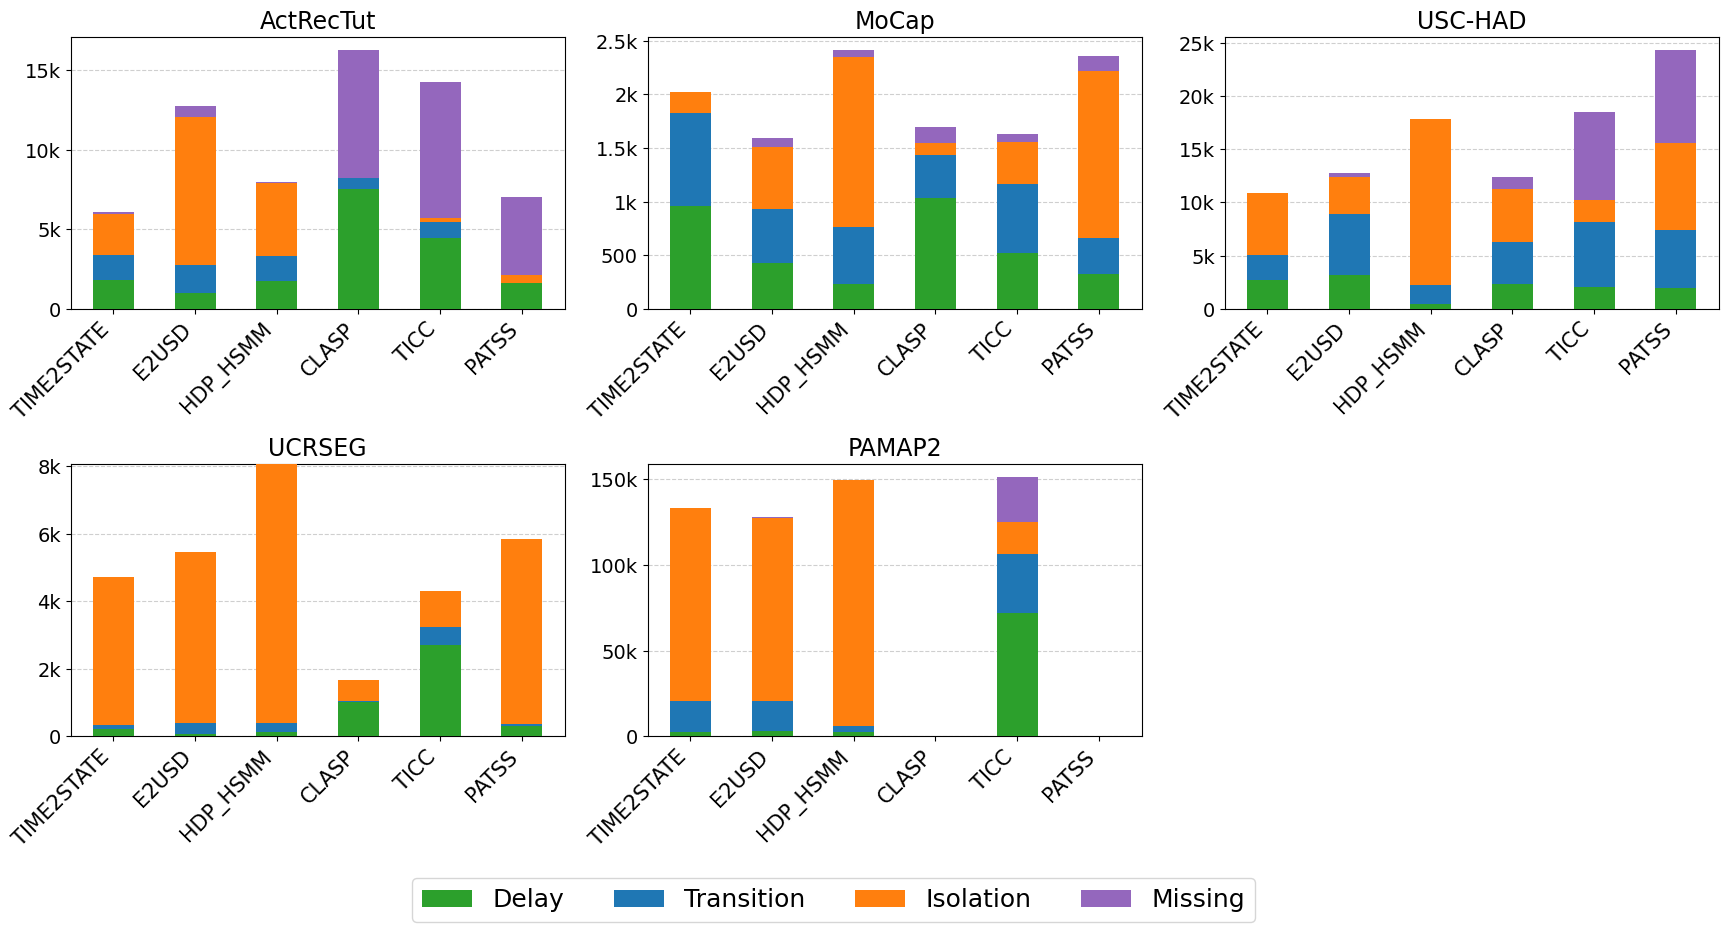

In [26]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# These lists should be defined, e.g., from your existing notebook context
# Example values if not already defined:
if 'current_estimators' not in globals():
    current_estimators = ["time2state", "e2usd", "hdp_hsmm", "clasp", "ticc", "patss"]
if 'current_datasets' not in globals():
    current_datasets = ["MoCap", "ActRecTut", "USC-HAD", "UCRSEG", "PAMAP2"]

# Define the order for plotting datasets
plot_order_datasets = ["ActRecTut", "MoCap", "USC-HAD", "UCRSEG", "PAMAP2"]

# Initialize dictionary to store per-dataset scores
# It's initialized based on current_datasets to capture all data,
# then plot_order_datasets controls the plotting.
plot_data_per_dataset = {
    ds: {
        algo: {
            'ari': np.nan, 'wari': np.nan,
            'sms_score': np.nan,
            'delay_size': 0.0, 'transition_size': 0.0,
            'isolation_size': 0.0, 'missing_size': 0.0
        } for algo in current_estimators
    } for ds in current_datasets # Use all available datasets for data collection
}

# 1. Process list_of_dfs (from CELL 16) for ARI and WARI scores
if 'list_of_dfs' in globals() and isinstance(list_of_dfs, list):
    for df_item in list_of_dfs:
        if not isinstance(df_item, pd.DataFrame) or df_item.empty:
            continue
        # Ensure 'estimator' and 'dataset_csv_name' columns exist and are not empty
        if 'estimator' not in df_item.columns or df_item['estimator'].empty or \
           'dataset_csv_name' not in df_item.columns or df_item['dataset_csv_name'].empty:
            continue
        algo = df_item['estimator'].iloc[0]
        dataset_name_from_csv = df_item['dataset_csv_name'].iloc[0]

        if algo in current_estimators and dataset_name_from_csv in plot_data_per_dataset:
            if 'ari' in df_item.columns and not df_item['ari'].empty:
                mean_ari_for_dataset = df_item['ari'].mean()
                if not pd.isna(mean_ari_for_dataset):
                    plot_data_per_dataset[dataset_name_from_csv][algo]['ari'] = mean_ari_for_dataset
            if 'wari' in df_item.columns and not df_item['wari'].empty:
                mean_wari_for_dataset = df_item['wari'].mean()
                if not pd.isna(mean_wari_for_dataset):
                    plot_data_per_dataset[dataset_name_from_csv][algo]['wari'] = mean_wari_for_dataset
else:
    print("Warning: 'list_of_dfs' not found or is not a list. ARI and WARI scores might be missing or incomplete.")

# 2. Process list_of_dataframes_per_algo (from CELL 17) for SMS scores and error components
if 'list_of_dataframes_per_algo' in globals() and isinstance(list_of_dataframes_per_algo, list):
    for df_algo_all_datasets in list_of_dataframes_per_algo:
        if not isinstance(df_algo_all_datasets, pd.DataFrame) or df_algo_all_datasets.empty:
            continue
        
        if 'algorithm' not in df_algo_all_datasets.columns or df_algo_all_datasets['algorithm'].empty:
            continue
        algo = df_algo_all_datasets['algorithm'].iloc[0]

        if algo in current_estimators:
            for _, row in df_algo_all_datasets.iterrows():
                if 'dataset' not in row:
                    continue
                dataset_name = row['dataset']
                if dataset_name in plot_data_per_dataset:
                    # SMS score is still collected, though not directly plotted as before
                    plot_data_per_dataset[dataset_name][algo]['sms_score'] = row['avg_score'] if 'avg_score' in row and not pd.isna(row['avg_score']) else np.nan
                    
                    # Store raw error sizes
                    plot_data_per_dataset[dataset_name][algo]['delay_size'] = row['avg_delay_size'] if 'avg_delay_size' in row and not pd.isna(row['avg_delay_size']) else 0.0
                    plot_data_per_dataset[dataset_name][algo]['transition_size'] = row['avg_transition_size'] if 'avg_transition_size' in row and not pd.isna(row['avg_transition_size']) else 0.0
                    plot_data_per_dataset[dataset_name][algo]['isolation_size'] = row['avg_isolation_size'] if 'avg_isolation_size' in row and not pd.isna(row['avg_isolation_size']) else 0.0
                    plot_data_per_dataset[dataset_name][algo]['missing_size'] = row['avg_missing_size'] if 'avg_missing_size' in row and not pd.isna(row['avg_missing_size']) else 0.0
else:
    print("Warning: 'list_of_dataframes_per_algo' not found or is not a list. SMS scores and error component data might be missing or incomplete.")

# Formatter for y-axis to use "k" for thousands
def k_formatter(x, pos):
    if x == 0: return '0'
    # Check if x is a multiple of 1000 (and not zero itself)
    if x % 1000 == 0 and x != 0:
         return f'{int(x/1000)}k'
    # For other numbers >= 1000, use one decimal place like 1.5k, 23.4k
    if abs(x) >= 1000:
        return f'{x/1000:.1f}k'
    # For numbers < 1000, show as integer
    return f'{x:.0f}'


# 4. & 5. Plotting per dataset (Modified for stacked error component sizes)
algorithms_plot_order = current_estimators
num_algos = len(algorithms_plot_order)
x_indices = np.arange(num_algos)  # Centered indices for each algorithm
single_bar_width = 0.5  # Width for the single stacked bar

fig, axs = plt.subplots(2, 3, figsize=(18, 10)) # Reduced figure width
axs_flat = axs.flatten()

for i, dataset_name in enumerate(plot_order_datasets):
    ax = axs_flat[i]
    
    if dataset_name not in plot_data_per_dataset:
        ax.set_title(f"{dataset_name}\n(Data not available)", fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        continue

    delay_sizes = []
    transition_sizes = []
    isolation_sizes = []
    missing_sizes = []

    for algo in algorithms_plot_order:
        algo_data = plot_data_per_dataset[dataset_name].get(algo, {}) # Use .get for safety
        
        s_delay = algo_data.get('delay_size', 0.0)
        s_transition = algo_data.get('transition_size', 0.0)
        s_isolation = algo_data.get('isolation_size', 0.0)
        s_missing = algo_data.get('missing_size', 0.0)
        
        s_delay = 0.0 if pd.isna(s_delay) else float(s_delay)
        s_transition = 0.0 if pd.isna(s_transition) else float(s_transition)
        s_isolation = 0.0 if pd.isna(s_isolation) else float(s_isolation)
        s_missing = 0.0 if pd.isna(s_missing) else float(s_missing)

        delay_sizes.append(max(0, s_delay))
        transition_sizes.append(max(0, s_transition))
        isolation_sizes.append(max(0, s_isolation))
        missing_sizes.append(max(0, s_missing))

    s_delay_np = np.array(delay_sizes)
    s_transition_np = np.array(transition_sizes)
    s_isolation_np = np.array(isolation_sizes)
    s_missing_np = np.array(missing_sizes)

    bottom_tr = s_delay_np
    bottom_is = s_delay_np + s_transition_np
    bottom_mi = s_delay_np + s_transition_np + s_isolation_np

    ax.bar(x_indices, s_delay_np, single_bar_width, label='Delay' if i == 0 else "", color='tab:green', zorder=3)
    ax.bar(x_indices, s_transition_np, single_bar_width, bottom=bottom_tr, label='Transition' if i == 0 else "", color='tab:blue', zorder=3)
    ax.bar(x_indices, s_isolation_np, single_bar_width, bottom=bottom_is, label='Isolation' if i == 0 else "", color='tab:orange', zorder=3)
    ax.bar(x_indices, s_missing_np, single_bar_width, bottom=bottom_mi, label='Missing' if i == 0 else "", color='tab:purple', zorder=3)

    ax.set_title(dataset_name, fontsize=17)
    ax.set_xticks(x_indices)
    ax.set_xticklabels([algo.upper() for algo in algorithms_plot_order], rotation=45, ha="right", fontsize=15)
    
    ax.yaxis.set_major_formatter(FuncFormatter(k_formatter)) # Apply k-formatter for y-ticks
    ax.tick_params(axis='y', labelsize=14) # Adjusted y-tick label size slightly for "k" format
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0)
    ax.set_ylim(bottom=0) 
    # ax.set_ylabel('Average Error Component Size', fontsize=16) # Removed individual y-axis label

# Hide unused subplots
if len(plot_order_datasets) < len(axs_flat):
    for j in range(len(plot_order_datasets), len(axs_flat)):
        axs_flat[j].set_visible(False)

# Legend
handles, labels = axs_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), ncol=4, fontsize=18)

plt.tight_layout(rect=[0.03, 0.08, 1, 0.95]) # Adjust rect for removed y-labels and legend

figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
file_path = os.path.join(figures_dir, "per_dataset_avg_error_component_sizes.pdf")

plt.savefig(file_path)
plt.show()


## Impact of SMS parameters on segmentation scores

Load SMS scores from 100 evaluations with random uniform [0-1] weights for each error type

In [93]:
def load_score_averages(
    base_results_path: str = RESULTS,
    task: str = "multivariate",
    folder: str = "score"
) -> pd.DataFrame:
    """
    Reads SMS‐weights CSVs under:
      {base_results_path}/{task}/{subfolder}/{algo}/*.csv
    Averages each file's numeric columns over its rows,
    and returns a DataFrame with one row per (algorithm, dataset),
    with 'dataset' as the first column.
    """
    sms_dir = os.path.join(base_results_path, task, folder)
    records = []
    if not os.path.isdir(sms_dir):
        raise FileNotFoundError(f"Directory not found: {sms_dir}")
    for algo in os.listdir(sms_dir):
        algo_dir = os.path.join(sms_dir, algo)
        if not os.path.isdir(algo_dir):
            continue
        for fname in os.listdir(algo_dir):
            if not fname.endswith(".csv"):
                continue
            dataset = fname[:-4]
            path = os.path.join(algo_dir, fname)
            try:
                df = pd.read_csv(path)
            except Exception as e:
                print(f"Skipping {path}: {e}")
                continue
            means = df.mean(numeric_only=True)
            row = {"algorithm": algo, "dataset": dataset}
            row.update(means.to_dict())
            records.append(row)
    df = pd.DataFrame(records)
    # move 'dataset' to be the first column
    if "dataset" in df.columns:
        cols = df.columns.tolist()
        cols.insert(0, cols.pop(cols.index("dataset")))
        df = df[cols]
    return df

df_sms_weights_avg = load_score_averages(folder="score_sms_weights")
print(df_sms_weights_avg.head())

          dataset algorithm     sms_0     sms_1     sms_2     sms_3     sms_4  \
0       ActRecTut  hdp_hsmm  0.715312  0.701970  0.710833  0.707416  0.696390   
1  Needle_Passing  hdp_hsmm  0.286558  0.253750  0.318157  0.283266  0.104745   
2         USC-HAD  hdp_hsmm  0.535371  0.540399  0.534690  0.527523  0.535002   
3      Knot_Tying  hdp_hsmm  0.309983  0.258569  0.330075  0.302829  0.152774   
4        Suturing  hdp_hsmm  0.269961  0.233467  0.304307  0.270390  0.095519   

      sms_5     sms_6     sms_7  ...    sms_90    sms_91    sms_92    sms_93  \
0  0.731088  0.731664  0.708580  ...  0.705704  0.743699  0.724455  0.695990   
1  0.336036  0.320596  0.217866  ...  0.312883  0.213801  0.353617  0.275650   
2  0.535216  0.542534  0.538243  ...  0.535774  0.552891  0.537251  0.539863   
3  0.374213  0.355496  0.246017  ...  0.318661  0.287401  0.376810  0.268769   
4  0.321658  0.301941  0.197872  ...  0.299433  0.193703  0.340433  0.257611   

     sms_94    sms_95    sms_96 

Remove datasets out of scope, and compute SMS score std for each time series and display average std

In [96]:
# Remove specified datasets from the time‐series lengths DataFrame
datasets_to_remove = ['Suturing', 'Knot_Tying', 'Needle_Passing']
df_sms_weights_avg = df_sms_weights_avg[~df_sms_weights_avg['dataset'].isin(datasets_to_remove)]
# Display the filtered DataFrame (optional)
df_sms_weights_avg.head()

# Compute the row‐wise standard deviation across numeric columns (ignoring NaNs)
df_sms_weights_avg['std'] = df_sms_weights_avg.std(axis=1, numeric_only=True)
mean_std = df_sms_weights_avg['std'].mean(axis=0)
print(f"Mean of the standard deviations: {mean_std}")

Mean of the standard deviations: 0.06363866926788678


Displaying a subsample of scores

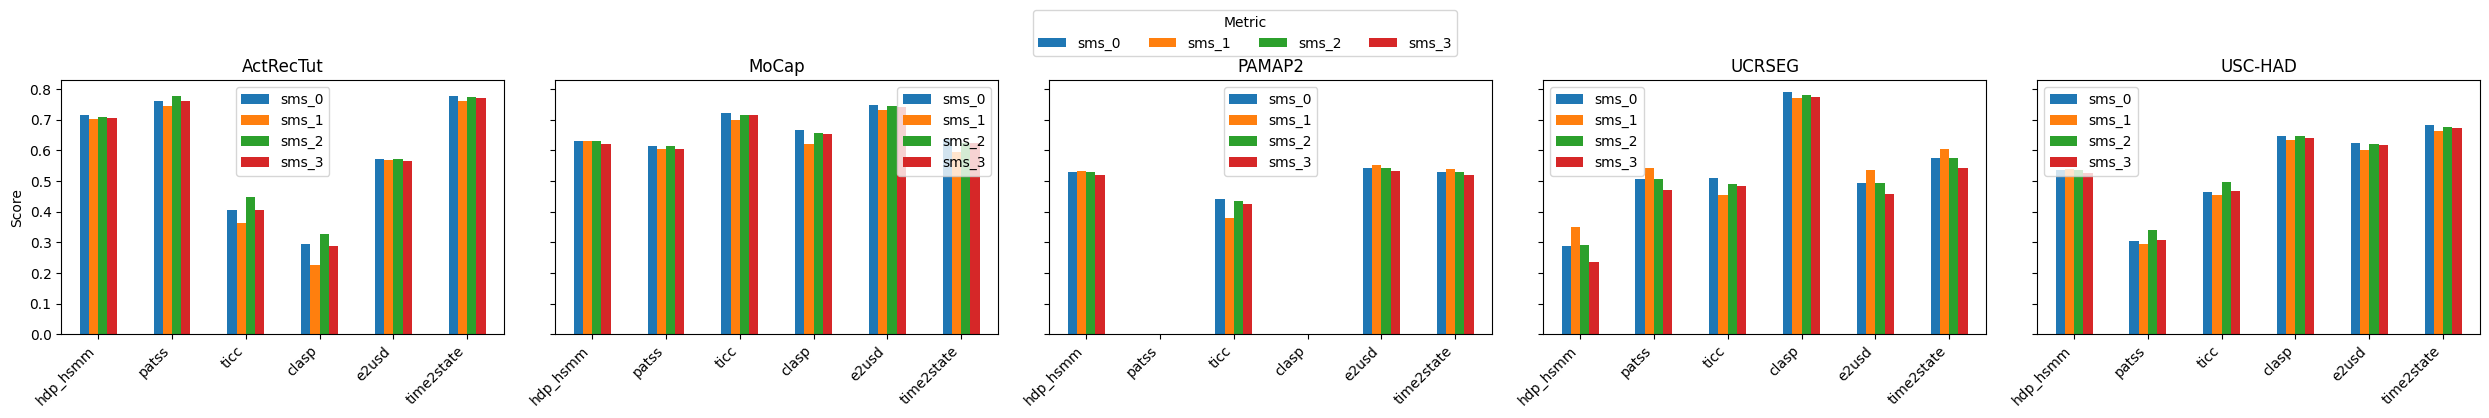

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics_by_dataset(
    df,
    dataset_col='dataset',
    estimator_col='algorithm',
    metrics=None,
    exclude_datasets=None,
    figsize_per_plot=(5, 4),
    sharey=True
):
    """
    Plot one subplot per dataset showing bar charts of the given metrics
    for each algorithm on the x-axis.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing at least columns for dataset, algorithm, and the metrics.
    dataset_col : str, default 'dataset'
        Name of the column in df identifying the dataset.
    estimator_col : str, default 'algorithm'
        Name of the column in df identifying the algorithm.
    metrics : list of str or None, default None
        List of column names in df to plot. If None, infer all numeric cols except dataset.
    exclude_datasets : list of str or None, default None
        List of dataset names to omit from plotting.
    figsize_per_plot : tuple, default (5, 4)
        Width and height per subplot in inches.
    sharey : bool, default True
        Whether to share the y-axis among subplots.

    Returns
    -------
    fig, axes : matplotlib Figure and array of Axes
    """
    if exclude_datasets is None:
        exclude_datasets = []

    # infer metrics if not provided
    if metrics is None:
        metrics = [
            c for c in df.select_dtypes(include='number').columns
            if c not in (dataset_col,)
        ]

    # get sorted unique datasets, then filter out any to exclude
    all_ds = sorted(df[dataset_col].unique())
    datasets = [ds for ds in all_ds if ds not in exclude_datasets]
    n = len(datasets)

    # create subplots
    fig, axes = plt.subplots(
        nrows=1, ncols=n,
        figsize=(figsize_per_plot[0] * n, figsize_per_plot[1]),
        sharey=sharey, squeeze=False
    )
    axes = axes.flatten()

    for ax, ds in zip(axes, datasets):
        sub = df[df[dataset_col] == ds]
        pivot = sub.set_index(estimator_col)[metrics]
        pivot.plot(kind='bar', ax=ax)
        ax.set_title(ds)
        ax.set_xlabel('')
        ax.set_xticklabels(pivot.index, rotation=45, ha='right')
        ax.set_ylabel('Score')

    # single legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, title='Metric',
        loc='upper center', ncol=len(metrics),
        bbox_to_anchor=(0.5, 1.05)
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    return fig, axes

plot_metrics_by_dataset(df_sms_weights_avg, metrics=['sms_0', 'sms_1', 'sms_2', 'sms_3'], exclude_datasets=['Suturing', 'Knot_Tying', 'Needle_Passing'])